In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import math as math
import time as time

import numpy as np
import scipy.sparse as sp

import mdptoolbox.example
import mdptoolbox.util as _util

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# from mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning

## Algorithms

In [2]:
_MSG_STOP_MAX_ITER = "Iterating stopped due to maximum number of iterations " \
    "condition."
_MSG_STOP_EPSILON_OPTIMAL_POLICY = "Iterating stopped, epsilon-optimal " \
    "policy found."
_MSG_STOP_EPSILON_OPTIMAL_VALUE = "Iterating stopped, epsilon-optimal value " \
    "function found."
_MSG_STOP_UNCHANGING_POLICY = "Iterating stopped, unchanging policy found."


def _computeDimensions(transition):
    A = len(transition)
    try:
        if transition.ndim == 3:
            S = transition.shape[1]
        else:
            S = transition[0].shape[0]
    except AttributeError:
        S = transition[0].shape[0]
    return S, A


def _printVerbosity(iteration, variation):
    if isinstance(variation, float):
        print("{:>10}{:>12f}".format(iteration, variation))
    elif isinstance(variation, int):
        print("{:>10}{:>12d}".format(iteration, variation))
    else:
        print("{:>10}{:>12}".format(iteration, variation))

### mdp base

In [3]:
class MDP(object):

    """A Markov Decision Problem.

    Let ``S`` = the number of states, and ``A`` = the number of acions.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. These can be defined in a variety of
        ways. The simplest is a numpy array that has the shape ``(A, S, S)``,
        though there are other possibilities. It can be a tuple or list or
        numpy object array of length ``A``, where each element contains a numpy
        array or matrix that has the shape ``(S, S)``. This "list of matrices"
        form is useful when the transition matrices are sparse as
        ``scipy.sparse.csr_matrix`` matrices can be used. In summary, each
        action's transition matrix must be indexable like ``transitions[a]``
        where ``a`` ∈ {0, 1...A-1}, and ``transitions[a]`` returns an ``S`` ×
        ``S`` array-like object.
    reward : array
        Reward matrices or vectors. Like the transition matrices, these can
        also be defined in a variety of ways. Again the simplest is a numpy
        array that has the shape ``(S, A)``, ``(S,)`` or ``(A, S, S)``. A list
        of lists can be used, where each inner list has length ``S`` and the
        outer list has length ``A``. A list of numpy arrays is possible where
        each inner array can be of the shape ``(S,)``, ``(S, 1)``, ``(1, S)``
        or ``(S, S)``. Also ``scipy.sparse.csr_matrix`` can be used instead of
        numpy arrays. In addition, the outer list can be replaced by any object
        that can be indexed like ``reward[a]`` such as a tuple or numpy object
        array of length ``A``.
    discount : float
        Discount factor. The per time-step discount factor on future rewards.
        Valid values are greater than 0 upto and including 1. If the discount
        factor is 1, then convergence is cannot be assumed and a warning will
        be displayed. Subclasses of ``MDP`` may pass ``None`` in the case where
        the algorithm does not use a discount factor.
    epsilon : float
        Stopping criterion. The maximum change in the value function at each
        iteration is compared against ``epsilon``. Once the change falls below
        this value, then the value function is considered to have converged to
        the optimal value function. Subclasses of ``MDP`` may pass ``None`` in
        the case where the algorithm does not use an epsilon-optimal stopping
        criterion.
    max_iter : int
        Maximum number of iterations. The algorithm will be terminated once
        this many iterations have elapsed. This must be greater than 0 if
        specified. Subclasses of ``MDP`` may pass ``None`` in the case where
        the algorithm does not use a maximum number of iterations.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Attributes
    ----------
    P : array
        Transition probability matrices.
    R : array
        Reward vectors.
    V : tuple
        The optimal value function. Each element is a float corresponding to
        the expected value of being in that state assuming the optimal policy
        is followed.
    discount : float
        The discount rate on future rewards.
    max_iter : int
        The maximum number of iterations.
    policy : tuple
        The optimal policy.
    time : float
        The time used to converge to the optimal policy.
    verbose : boolean
        Whether verbose output should be displayed or not.

    Methods
    -------
    run
        Implemented in child classes as the main algorithm loop. Raises an
        exception if it has not been overridden.
    setSilent
        Turn the verbosity off
    setVerbose
        Turn the verbosity on

    """

    def __init__(self, transitions, reward, discount, epsilon, max_iter,
                 skip_check=False):
        # Initialise a MDP based on the input parameters.

        # if the discount is None then the algorithm is assumed to not use it
        # in its computations
        if discount is not None:
            self.discount = float(discount)
            assert 0.0 < self.discount <= 1.0, (
                "Discount rate must be in ]0; 1]"
            )
            if self.discount == 1:
                print("WARNING: check conditions of convergence. With no "
                      "discount, convergence can not be assumed.")

        # if the max_iter is None then the algorithm is assumed to not use it
        # in its computations
        if max_iter is not None:
            self.max_iter = int(max_iter)
            assert self.max_iter > 0, (
                "The maximum number of iterations must be greater than 0."
            )

        # check that epsilon is something sane
        if epsilon is not None:
            self.epsilon = float(epsilon)
            assert self.epsilon > 0, "Epsilon must be greater than 0."

        if not skip_check:
            # We run a check on P and R to make sure they are describing an
            # MDP. If an exception isn't raised then they are assumed to be
            # correct.
            _util.check(transitions, reward)

        self.S, self.A = _computeDimensions(transitions)
        self.P = self._computeTransition(transitions)
        self.R = self._computeReward(reward, transitions)

        # the verbosity is by default turned off
        self.verbose = False
        # Initially the time taken to perform the computations is set to None
        self.time = None
        # set the initial iteration count to zero
        self.iter = 0
        # V should be stored as a vector ie shape of (S,) or (1, S)
        self.V = None
        # policy can also be stored as a vector
        self.policy = None

    def __repr__(self):
        P_repr = "P: \n"
        R_repr = "R: \n"
        for aa in range(self.A):
            P_repr += repr(self.P[aa]) + "\n"
            R_repr += repr(self.R[aa]) + "\n"
        return(P_repr + "\n" + R_repr)

    def _bellmanOperator(self, V=None):
        # Apply the Bellman operator on the value function.
        #
        # Updates the value function and the Vprev-improving policy.
        #
        # Returns: (policy, value), tuple of new policy and its value
        #
        # If V hasn't been sent into the method, then we assume to be working
        # on the objects V attribute
        if V is None:
            # this V should be a reference to the data rather than a copy
            V = self.V
        else:
            # make sure the user supplied V is of the right shape
            try:
                assert V.shape in ((self.S,), (1, self.S)), "V is not the " \
                    "right shape (Bellman operator)."
            except AttributeError:
                raise TypeError("V must be a numpy array or matrix.")
        # Looping through each action the the Q-value matrix is calculated.
        # P and V can be any object that supports indexing, so it is important
        # that you know they define a valid MDP before calling the
        # _bellmanOperator method. Otherwise the results will be meaningless.
        Q = np.empty((self.A, self.S))
        for aa in range(self.A):
            Q[aa] = self.R[aa] + self.discount * self.P[aa].dot(V)
        # Get the policy and value, for now it is being returned but...
        # Which way is better?
        # 1. Return, (policy, value)
        return (Q.argmax(axis=0), Q.max(axis=0))
        # 2. update self.policy and self.V directly
        # self.V = Q.max(axis=1)
        # self.policy = Q.argmax(axis=1)

    def _computeTransition(self, transition):
        return tuple(transition[a] for a in range(self.A))

    def _computeReward(self, reward, transition):
        # Compute the reward for the system in one state chosing an action.
        # Arguments
        # Let S = number of states, A = number of actions
        # P could be an array with 3 dimensions or  a cell array (1xA),
        # each cell containing a matrix (SxS) possibly sparse
        # R could be an array with 3 dimensions (SxSxA) or  a cell array
        # (1xA), each cell containing a sparse matrix (SxS) or a 2D
        # array(SxA) possibly sparse
        try:
            if reward.ndim == 1:
                return self._computeVectorReward(reward)
            elif reward.ndim == 2:
                return self._computeArrayReward(reward)
            else:
                r = tuple(map(self._computeMatrixReward, reward, transition))
                return r
        except (AttributeError, ValueError):
            if len(reward) == self.A:
                r = tuple(map(self._computeMatrixReward, reward, transition))
                return r
            else:
                return self._computeVectorReward(reward)

    def _computeVectorReward(self, reward):
        if sp.issparse(reward):
            raise NotImplementedError
        else:
            r = np.array(reward).reshape(self.S)
            return tuple(r for a in range(self.A))

    def _computeArrayReward(self, reward):
        if sp.issparse(reward):
            raise NotImplementedError
        else:
            def func(x):
                return np.array(x).reshape(self.S)

            return tuple(func(reward[:, a]) for a in range(self.A))

    def _computeMatrixReward(self, reward, transition):
        if sp.issparse(reward):
            # An approach like this might be more memory efficeint
            # reward.data = reward.data * transition[reward.nonzero()]
            # return reward.sum(1).A.reshape(self.S)
            # but doesn't work as it is.
            return reward.multiply(transition).sum(1).A.reshape(self.S)
        elif sp.issparse(transition):
            return transition.multiply(reward).sum(1).A.reshape(self.S)
        else:
            return np.multiply(transition, reward).sum(1).reshape(self.S)

    def _startRun(self):
        if self.verbose:
            _printVerbosity('Iteration', 'Variation')

        self.time = time.time()

    def _endRun(self):
        # store value and policy as tuples
        self.V = tuple(self.V.tolist())

        try:
            self.policy = tuple(self.policy.tolist())
        except AttributeError:
            self.policy = tuple(self.policy)

        self.time = time.time() - self.time

    def run(self):
        """Raises error because child classes should implement this function.
        """
        raise NotImplementedError("You should create a run() method.")

    def setSilent(self):
        """Set the MDP algorithm to silent mode."""
        self.verbose = False

    def setVerbose(self):
        """Set the MDP algorithm to verbose mode."""
        self.verbose = True

### Policy Iteration

In [4]:
class PolicyIteration(MDP):

    """A discounted MDP solved using the policy iteration algorithm.

    Arguments
    ---------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    policy0 : array, optional
        Starting policy.
    max_iter : int, optional
        Maximum number of iterations. See the documentation for the ``MDP``
        class for details. Default is 1000.
    eval_type : int or string, optional
        Type of function used to evaluate policy. 0 or "matrix" to solve as a
        set of linear equations. 1 or "iterative" to solve iteratively.
        Default: 0.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    V : tuple
        value function
    policy : tuple
        optimal policy
    iter : int
        number of done iterations
    time : float
        used CPU time

    Notes
    -----
    In verbose mode, at each iteration, displays the number
    of differents actions between policy n-1 and n

    Examples
    --------
    >>> import mdptoolbox, mdptoolbox.example
    >>> P, R = mdptoolbox.example.rand(10, 3)
    >>> pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.9)
    >>> pi.run()

    >>> P, R = mdptoolbox.example.forest()
    >>> pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.9)
    >>> pi.run()
    >>> expected = (26.244000000000014, 29.484000000000016, 33.484000000000016)
    >>> all(expected[k] - pi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> pi.policy
    (0, 0, 0)
    """

    def __init__(self, transitions, reward, discount, policy0=None,
                 max_iter=1000, eval_type=0, skip_check=False):
        # Initialise a policy iteration MDP.
        #
        # Set up the MDP, but don't need to worry about epsilon values
        MDP.__init__(self, transitions, reward, discount, None, max_iter,
                     skip_check=skip_check)
        # Check if the user has supplied an initial policy. If not make one.
        if policy0 is None:
            # Initialise the policy to the one which maximises the expected
            # immediate reward
            null = np.zeros(self.S)
            self.policy, null = self._bellmanOperator(null)
            del null
        else:
            # Use the policy that the user supplied
            # Make sure it is a numpy array
            policy0 = np.array(policy0)
            # Make sure the policy is the right size and shape
            assert policy0.shape in ((self.S, ), (self.S, 1), (1, self.S)), \
                "'policy0' must a vector with length S."
            # reshape the policy to be a vector
            policy0 = policy0.reshape(self.S)
            # The policy can only contain integers between 0 and S-1
            msg = "'policy0' must be a vector of integers between 0 and S-1."
            assert not np.mod(policy0, 1).any(), msg
            assert (policy0 >= 0).all(), msg
            assert (policy0 < self.S).all(), msg
            self.policy = policy0
        # set the initial values to zero
        self.V = np.zeros(self.S)
        # Do some setup depending on the evaluation type
        if eval_type in (0, "matrix"):
            self.eval_type = "matrix"
        elif eval_type in (1, "iterative"):
            self.eval_type = "iterative"
        else:
            raise ValueError("'eval_type' should be '0' for matrix evaluation "
                             "or '1' for iterative evaluation. The strings "
                             "'matrix' and 'iterative' can also be used.")

    def _computePpolicyPRpolicy(self):
        # Compute the transition matrix and the reward matrix for a policy.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA)  = transition matrix
        #     P could be an array with 3 dimensions or a cell array (1xA),
        #     each cell containing a matrix (SxS) possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #     R could be an array with 3 dimensions (SxSxA) or
        #     a cell array (1xA), each cell containing a sparse matrix (SxS) or
        #     a 2D array(SxA) possibly sparse
        # policy(S) = a policy
        #
        # Evaluation
        # ----------
        # Ppolicy(SxS)  = transition matrix for policy
        # PRpolicy(S)   = reward matrix for policy
        #
        Ppolicy = np.empty((self.S, self.S))
        Rpolicy = np.zeros(self.S)
        for aa in range(self.A):  # avoid looping over S
            # the rows that use action a.
            ind = (self.policy == aa).nonzero()[0]
            # if no rows use action a, then no need to assign this
            if ind.size > 0:
                try:
                    Ppolicy[ind, :] = self.P[aa][ind, :]
                except ValueError:
                    Ppolicy[ind, :] = self.P[aa][ind, :].todense()
                # PR = self._computePR() # an apparently uneeded line, and
                # perhaps harmful in this implementation c.f.
                # mdp_computePpolicyPRpolicy.m
                Rpolicy[ind] = self.R[aa][ind]
        # self.R cannot be sparse with the code in its current condition, but
        # it should be possible in the future. Also, if R is so big that its
        # a good idea to use a sparse matrix for it, then converting PRpolicy
        # from a dense to sparse matrix doesn't seem very memory efficient
        if type(self.R) is sp.csr_matrix:
            Rpolicy = sp.csr_matrix(Rpolicy)
        # self.Ppolicy = Ppolicy
        # self.Rpolicy = Rpolicy
        return (Ppolicy, Rpolicy)

    def _evalPolicyIterative(self, V0=0, epsilon=0.0001, max_iter=10000):
        # Evaluate a policy using iteration.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA)  = transition matrix
        #    P could be an array with 3 dimensions or
        #    a cell array (1xS), each cell containing a matrix possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #    R could be an array with 3 dimensions (SxSxA) or
        #    a cell array (1xA), each cell containing a sparse matrix (SxS) or
        #    a 2D array(SxA) possibly sparse
        # discount  = discount rate in ]0; 1[
        # policy(S) = a policy
        # V0(S)     = starting value function, optional (default : zeros(S,1))
        # epsilon   = epsilon-optimal policy search, upper than 0,
        #    optional (default : 0.0001)
        # max_iter  = maximum number of iteration to be done, upper than 0,
        #    optional (default : 10000)
        #
        # Evaluation
        # ----------
        # Vpolicy(S) = value function, associated to a specific policy
        #
        # Notes
        # -----
        # In verbose mode, at each iteration, displays the condition which
        # stopped iterations: epsilon-optimum value function found or maximum
        # number of iterations reached.
        #
        try:
            assert V0.shape in ((self.S, ), (self.S, 1), (1, self.S)), \
                "'V0' must be a vector of length S."
            policy_V = np.array(V0).reshape(self.S)
        except AttributeError:
            if V0 == 0:
                policy_V = np.zeros(self.S)
            else:
                policy_V = np.array(V0).reshape(self.S)

        policy_P, policy_R = self._computePpolicyPRpolicy()

        if self.verbose:
            _printVerbosity("Iteration", "V variation")

        itr = 0
        done = False
        while not done:
            itr += 1

            Vprev = policy_V
            policy_V = policy_R + self.discount * policy_P.dot(Vprev)

            variation = np.absolute(policy_V - Vprev).max()
            if self.verbose:
                _printVerbosity(itr, variation)

            # ensure |Vn - Vpolicy| < epsilon
            if variation < ((1 - self.discount) / self.discount) * epsilon:
                done = True
                if self.verbose:
                    print(_MSG_STOP_EPSILON_OPTIMAL_VALUE)
            elif itr == max_iter:
                done = True
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)

        self.V = policy_V

    def _evalPolicyMatrix(self):
        # Evaluate the value function of the policy using linear equations.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA) = transition matrix
        #      P could be an array with 3 dimensions or a cell array (1xA),
        #      each cell containing a matrix (SxS) possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #      R could be an array with 3 dimensions (SxSxA) or
        #      a cell array (1xA), each cell containing a sparse matrix (SxS)
        #      or a 2D array(SxA) possibly sparse
        # discount = discount rate in ]0; 1[
        # policy(S) = a policy
        #
        # Evaluation
        # ----------
        # Vpolicy(S) = value function of the policy
        #
        Ppolicy, Rpolicy = self._computePpolicyPRpolicy()
        # V = PR + gPV  => (I-gP)V = PR  => V = inv(I-gP)* PR
        self.V = np.linalg.solve(
            (sp.eye(self.S, self.S) - self.discount * Ppolicy), Rpolicy)

    def run(self):
        # Run the policy iteration algorithm.
        policy_li = [self.policy]
        val_li = [self.V]
        n_li = []
        self._startRun()

        while True:
            self.iter += 1

            #### policy evaluation ####
            # these _evalPolicy* functions will update the classes value
            # attribute
            if self.eval_type == "matrix":
                self._evalPolicyMatrix()
            elif self.eval_type == "iterative":
                self._evalPolicyIterative()

            #### policy improvement ####
            # This should update the classes policy attribute but leave the
            # value alone
            policy_next, val_next = self._bellmanOperator() ###########
            policy_li.append(policy_next)
            val_li.append(val_next)
            # calculate in how many places does the old policy disagree with
            # the new policy
            n_different = (policy_next != self.policy).sum()
            n_li.append(n_different)
            # if verbose then continue printing a table
            if self.verbose:
                _printVerbosity(self.iter, n_different)
            # Once the policy is unchanging of the maximum number of
            # of iterations has been reached then stop
            if n_different == 0:
                if self.verbose:
                    print(_MSG_STOP_UNCHANGING_POLICY)
                break
            elif self.iter == self.max_iter:
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)
                break
            else:
                self.policy = policy_next

        self._endRun()
        return policy_li, val_li, n_li

### Value Iteration

In [5]:
class ValueIteration(MDP):

    """A discounted MDP solved using the value iteration algorithm.

    Description
    -----------
    ValueIteration applies the value iteration algorithm to solve a
    discounted MDP. The algorithm consists of solving Bellman's equation
    iteratively.
    Iteration is stopped when an epsilon-optimal policy is found or after a
    specified number (``max_iter``) of iterations.
    This function uses verbose and silent modes. In verbose mode, the function
    displays the variation of ``V`` (the value function) for each iteration and
    the condition which stopped the iteration: epsilon-policy found or maximum
    number of iterations reached.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    epsilon : float, optional
        Stopping criterion. See the documentation for the ``MDP`` class for
        details.  Default: 0.01.
    max_iter : int, optional
        Maximum number of iterations. If the value given is greater than a
        computed bound, a warning informs that the computed bound will be used
        instead. By default, if ``discount`` is not equal to 1, a bound for
        ``max_iter`` is computed, otherwise ``max_iter`` = 1000. See the
        documentation for the ``MDP`` class for further details.
    initial_value : array, optional
        The starting value function. Default: a vector of zeros.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    V : tuple
        The optimal value function.
    policy : tuple
        The optimal policy function. Each element is an integer corresponding
        to an action which maximises the value function in that state.
    iter : int
        The number of iterations taken to complete the computation.
    time : float
        The amount of CPU time used to run the algorithm.

    Methods
    -------
    run()
        Do the algorithm iteration.
    setSilent()
        Sets the instance to silent mode.
    setVerbose()
        Sets the instance to verbose mode.

    Notes
    -----
    In verbose mode, at each iteration, displays the variation of V
    and the condition which stopped iterations: epsilon-optimum policy found
    or maximum number of iterations reached.

    Examples
    --------
    >>> import mdptoolbox, mdptoolbox.example
    >>> P, R = mdptoolbox.example.forest()
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.96)
    >>> vi.verbose
    False
    >>> vi.run()
    >>> expected = (5.93215488, 9.38815488, 13.38815488)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (0, 0, 0)
    >>> vi.iter
    4

    >>> import mdptoolbox
    >>> import numpy as np
    >>> P = np.array([[[0.5, 0.5],[0.8, 0.2]],[[0, 1],[0.1, 0.9]]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    >>> vi.run()
    >>> expected = (40.048625392716815, 33.65371175967546)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (1, 0)
    >>> vi.iter
    26

    >>> import mdptoolbox
    >>> import numpy as np
    >>> from scipy.sparse import csr_matrix as sparse
    >>> P = [None] * 2
    >>> P[0] = sparse([[0.5, 0.5],[0.8, 0.2]])
    >>> P[1] = sparse([[0, 1],[0.1, 0.9]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    >>> vi.run()
    >>> expected = (40.048625392716815, 33.65371175967546)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (1, 0)

    """

    def __init__(self, transitions, reward, discount, epsilon=0.01,
                 max_iter=10000, initial_value=0, skip_check=False):
        # Initialise a value iteration MDP.

        MDP.__init__(self, transitions, reward, discount, epsilon, max_iter,
                     skip_check=skip_check)

        # initialization of optional arguments
        if initial_value == 0:
            self.V = np.zeros(self.S)
        else:
            assert len(initial_value) == self.S, "The initial value must be " \
                "a vector of length S."
            self.V = np.array(initial_value).reshape(self.S)
        if self.discount < 1:
            # compute a bound for the number of iterations and update the
            # stored value of self.max_iter
            # self._boundIter(epsilon)
            # computation of threshold of variation for V for an epsilon-
            # optimal policy
            self.thresh = epsilon * (1 - self.discount) / self.discount
        else:  # discount == 1
            # threshold of variation for V for an epsilon-optimal policy
            self.thresh = epsilon

    def _boundIter(self, epsilon):
        # Compute a bound for the number of iterations.
        #
        # for the value iteration
        # algorithm to find an epsilon-optimal policy with use of span for the
        # stopping criterion
        #
        # Arguments -----------------------------------------------------------
        # Let S = number of states, A = number of actions
        #    epsilon   = |V - V*| < epsilon,  upper than 0,
        #        optional (default : 0.01)
        # Evaluation ----------------------------------------------------------
        #    max_iter  = bound of the number of iterations for the value
        #    iteration algorithm to find an epsilon-optimal policy with use of
        #    span for the stopping criterion
        #    cputime  = used CPU time
        #
        # See Markov Decision Processes, M. L. Puterman,
        # Wiley-Interscience Publication, 1994
        # p 202, Theorem 6.6.6
        # k =    max     [1 - S min[ P(j|s,a), p(j|s',a')] ]
        #     s,a,s',a'       j
        k = 0
        h = np.zeros(self.S)

        for ss in range(self.S):
            PP = np.zeros((self.A, self.S))
            for aa in range(self.A):
                try:
                    PP[aa] = self.P[aa][:, ss]
                except ValueError:
                    PP[aa] = self.P[aa][:, ss].todense().A1
            # minimum of the entire array.
            h[ss] = PP.min()

        k = 1 - h.sum()
        Vprev = self.V
        null, value = self._bellmanOperator()
        # p 201, Proposition 6.6.5
        span = _util.getSpan(value - Vprev)
        max_iter = (math.log((epsilon * (1 - self.discount) / self.discount) /
                    span) / math.log(self.discount * k))
        # self.V = Vprev

        self.max_iter = int(math.ceil(max_iter))

    def run(self):
        # Run the value iteration algorithm.
        self._startRun()
        policy_li = []
        val_li = []
        while True:
            self.iter += 1

            Vprev = self.V.copy()

            #### Bellman-iterate and update the argmax policy ###
            # Bellman Operator: compute policy and value functions
            self.policy, self.V = self._bellmanOperator() ################
            policy_li.append(self.policy)
            val_li.append(self.V)
            # The values, based on Q. For the function "max()": the option
            # "axis" means the axis along which to operate. In this case it
            # finds the maximum of the the rows. (Operates along the columns?)
            variation = _util.getSpan(self.V - Vprev)

            if self.verbose:
                _printVerbosity(self.iter, variation)

            if variation < self.thresh:
                if self.verbose:
                    print(_MSG_STOP_EPSILON_OPTIMAL_POLICY)
                break
            elif self.iter == self.max_iter:
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)
                break

        self._endRun()
        return policy_li, val_li

### Q Learning

In [6]:
class QLearning(MDP):

    """A discounted MDP solved using the Q learning algorithm.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    n_iter : int, optional
        Number of iterations to execute. This is ignored unless it is an
        integer greater than the default value. Defaut: 10,000.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    Q : array
        learned Q matrix (SxA)
    V : tuple
        learned value function (S).
    policy : tuple
        learned optimal policy (S).
    mean_discrepancy : array
        Vector of V discrepancy mean over 100 iterations. Then the length of
        this vector for the default value of N is 100 (N/100).

    Examples
    ---------
    >>> # These examples are reproducible only if random seed is set to 0 in
    >>> # both the random and numpy.random modules.
    >>> import numpy as np
    >>> import mdptoolbox, mdptoolbox.example
    >>> np.random.seed(0)
    >>> P, R = mdptoolbox.example.forest()
    >>> ql = mdptoolbox.mdp.QLearning(P, R, 0.96)
    >>> ql.run()
    >>> ql.Q
    array([[ 11.198909  ,  10.34652034],
           [ 10.74229967,  11.74105792],
           [  2.86980001,  12.25973286]])
    >>> expected = (11.198908998901134, 11.741057920409865, 12.259732864170232)
    >>> all(expected[k] - ql.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> ql.policy
    (0, 1, 1)

    >>> import mdptoolbox
    >>> import numpy as np
    >>> P = np.array([[[0.5, 0.5],[0.8, 0.2]],[[0, 1],[0.1, 0.9]]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> np.random.seed(0)
    >>> ql = mdptoolbox.mdp.QLearning(P, R, 0.9)
    >>> ql.run()
    >>> ql.Q
    array([[ 33.33010866,  40.82109565],
           [ 34.37431041,  29.67236845]])
    >>> expected = (40.82109564847122, 34.37431040682546)
    >>> all(expected[k] - ql.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> ql.policy
    (1, 0)

    """

    def __init__(self, transitions, reward, discount, n_iter=10000,
                 skip_check=False, learning_rate = 0.1, exploration_rate = 1, 
                 max_exploration_rate = 1, min_exploration_rate = 0.01, 
                 exploration_decay_rate = 0.001):
        # Initialise a Q-learning MDP.

        # The following check won't be done in MDP()'s initialisation, so let's
        # do it here
        self.verbose = False
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate

        self.max_iter = int(n_iter)
        assert self.max_iter >= 10000, "'n_iter' should be greater than 10000."

        if not skip_check:
            # We don't want to send this to MDP because _computePR should not
            #  be run on it, so check that it defines an MDP
            _util.check(transitions, reward)

        # Store P, S, and A
        self.S, self.A = _computeDimensions(transitions)
        self.P = self._computeTransition(transitions)

        self.R = reward
        self.discount = discount

        # Initialisations
        self.Q = np.zeros((self.S, self.A))
        self.mean_discrepancy = []

    def run(self):
        # Run the Q-learning algoritm.
        discrepancy = []
        policy_li = []
        val_li = []
        q_li = []
        # delta_li = []
        self.time = time.time()

        # initial state choice
        s = np.random.randint(0, self.S)

        for n in range(1, self.max_iter + 1):
            # Reinitialisation of trajectories every 100 transitions
            if (n % 100) == 0:
                s = np.random.randint(0, self.S)

            # Action choice : greedy with increasing probability
            # probability 1-(1/log(n+2)) can be changed
            # pn = np.random.random()
            # if pn < (1 - (1 / math.log(n + 2))):
            pn = np.random.uniform(0, 1)
            if self.exploration_rate > pn:
                # optimal_action = self.Q[s, :].max()
                a = self.Q[s, :].argmax()
            else:
                a = np.random.randint(0, self.A)

            # Simulating next state s_new and reward associated to <s,s_new,a>
            p_s_new = np.random.random()
            p = 0
            s_new = -1
            while (p < p_s_new) and (s_new < (self.S - 1)):
                s_new = s_new + 1
                p = p + self.P[a][s, s_new]

            try:
                r = self.R[a][s, s_new]
            except IndexError:
                try:
                    r = self.R[s, a]
                except IndexError:
                    r = self.R[s]

            # Updating the value of Q
            # Decaying update coefficient (1/sqrt(n+2)) can be changed
            delta = r + self.discount * self.Q[s_new, :].max() - self.Q[s, a]
            # dQ = (1 / math.sqrt(n + 2)) * delta
            dQ = self.learning_rate * delta
            self.Q[s, a] = self.Q[s, a] + dQ

            # delta_li.append(delta)
            q_li.append(self.Q)

            # current state is updated
            s = s_new

            # Computing and saving maximal values of the Q variation
            discrepancy.append(np.absolute(dQ))

            # Computing means all over maximal Q variations values
            if len(discrepancy) == 100:
                self.mean_discrepancy.append(np.mean(discrepancy))
                discrepancy = []

            if self.verbose:
                _printVerbosity(n, delta)

            # compute the value function and the policy
            self.V = self.Q.max(axis=1)
            self.policy = self.Q.argmax(axis=1)

            policy_li.append(self.policy)
            val_li.append(self.V)

            # update the exploration rate
            self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate-self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * n)
        
        if n == self.max_iter:
            if self.verbose:
                print(_MSG_STOP_MAX_ITER)
        self._endRun()
        return policy_li, val_li, q_li, self.mean_discrepancy

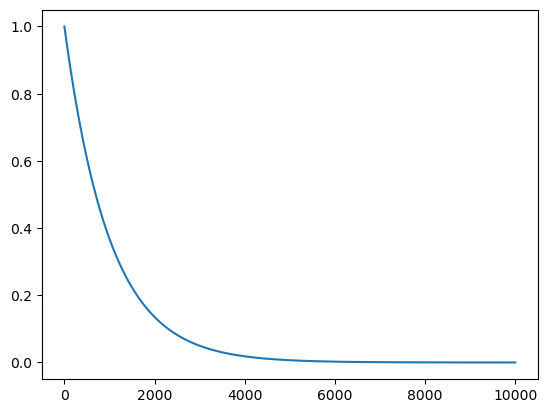

In [7]:
plt.plot([math.exp(-.001*n) for n in np.linspace(0,10000,10000)]);

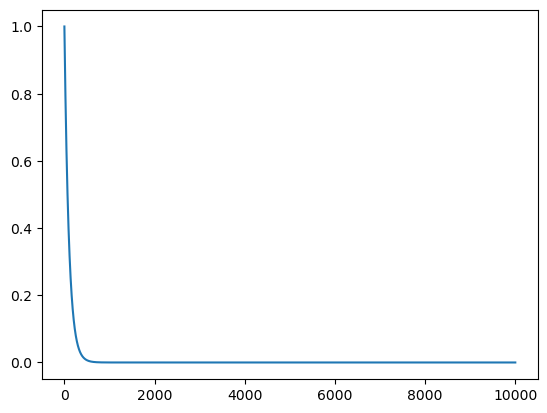

In [8]:
plt.plot([math.exp(-.01*n) for n in np.linspace(0,10000,10000)]);

In [9]:
# plt.plot([1 / math.log(n + 2) for n in np.linspace(0,10000,10000)]);

## Forest Management

### small

In [10]:
fm_sm_P, fm_sm_R = mdptoolbox.example.forest(S=50, r1=4, r2=2, p=0.1)

In [11]:
fm_sm_R

array([[0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [4., 2.]])

Policy iteration

In [12]:
fm_sm_pi = PolicyIteration(fm_sm_P, fm_sm_R, .99, policy0=np.zeros(len(fm_sm_R)))
# fm_sm_pi.setVerbose()
fm_sm_pi_policy_li, fm_sm_pi_val_li, fm_sm_pi_n_li = fm_sm_pi.run()

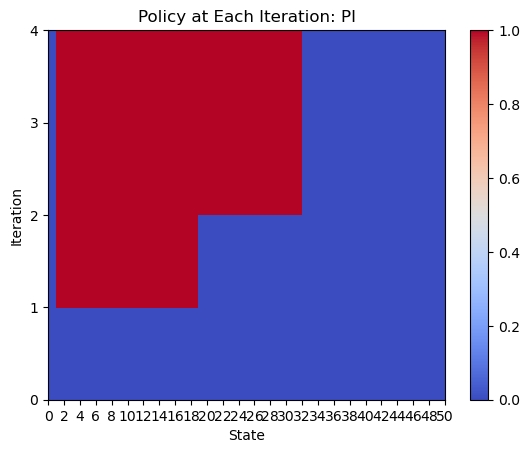

In [13]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_pi_policy_li), cmap='coolwarm')
plt.xticks(np.arange(0,51,2))
plt.yticks(np.arange(len(fm_sm_pi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Policy at Each Iteration: PI')
plt.colorbar();

In [14]:
# plt.plot(np.array(fm_sm_pi_val_li).mean(1))
# plt.xticks(np.arange(len(fm_sm_pi_val_li)+1))
# plt.xlabel('Iteration')
# plt.ylabel('"Average" Value');

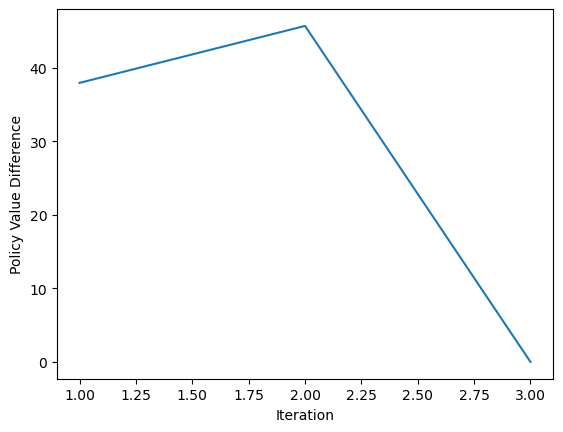

In [15]:
pd.DataFrame(np.array(fm_sm_pi_val_li)).diff().max(1).plot()
plt.xlabel('Iteration')
plt.ylabel('Policy Value Difference');

Value iteration

In [16]:
fm_sm_vi = ValueIteration(fm_sm_P, fm_sm_R, .99)
# fm_sm_vi.setVerbose()
fm_sm_vi_policy_li, fm_sm_vi_val_li = fm_sm_vi.run()

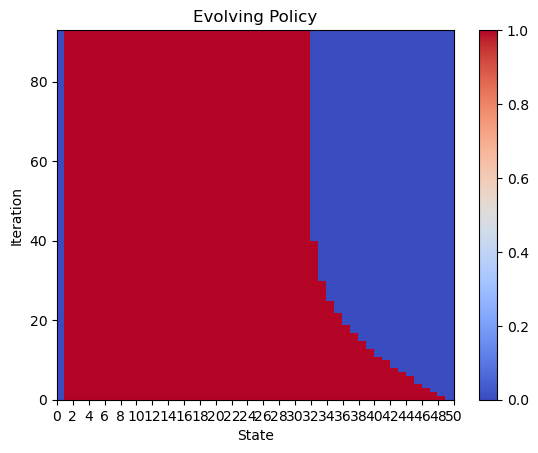

In [17]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_vi_policy_li), cmap='coolwarm')
plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

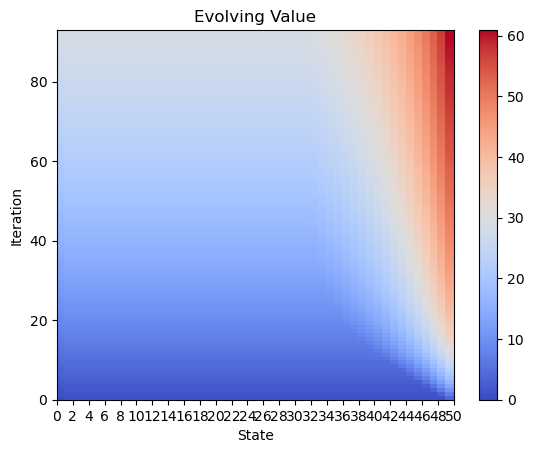

In [18]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_vi_val_li), cmap='coolwarm')
plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

Q learning

In [19]:
fm_sm_ql = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.7, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li, fm_sm_ql_val_li, fm_sm_ql_q_li, fm_sm_ql_delta_li = fm_sm_ql.run()

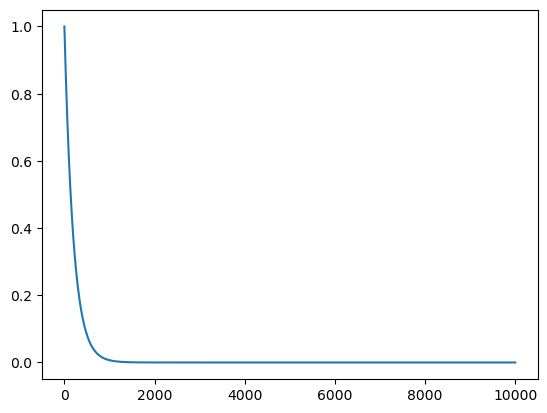

In [20]:
plt.plot([math.exp(-.005*n) for n in np.linspace(0,10000,10000)]);

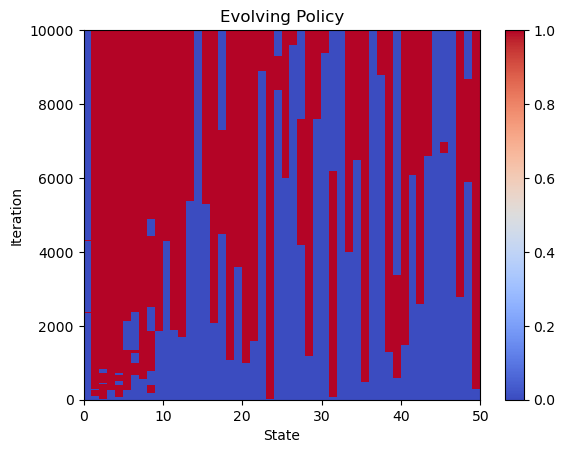

In [21]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_ql_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_ql_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

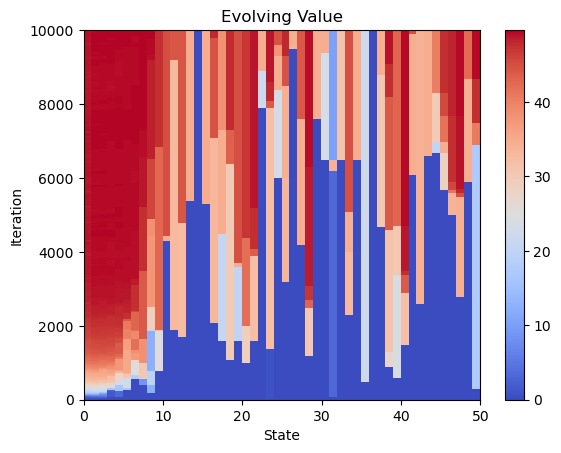

In [22]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_ql_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

In [23]:
# # plt.figure(figsize=(10,2))
# plt.pcolor(np.array(fm_sm_ql_q_li)[:,:,0], cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# # plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
# plt.ylabel('Iteration')
# plt.xlabel('State')
# plt.title('Evolving Q0')
# plt.colorbar();

In [24]:
# # plt.figure(figsize=(10,2))
# plt.pcolor(np.array(fm_sm_ql_q_li)[:,:,1], cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# # plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
# plt.ylabel('Iteration')
# plt.xlabel('State')
# plt.title('Evolving Q1')
# plt.colorbar();

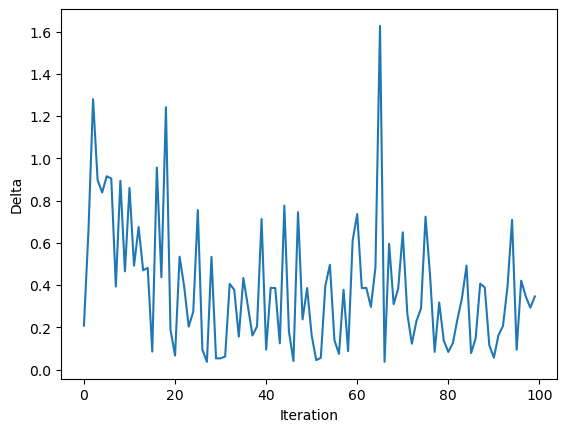

In [25]:
plt.plot(fm_sm_ql_delta_li)
plt.xlabel('Iteration')
plt.ylabel('Delta');

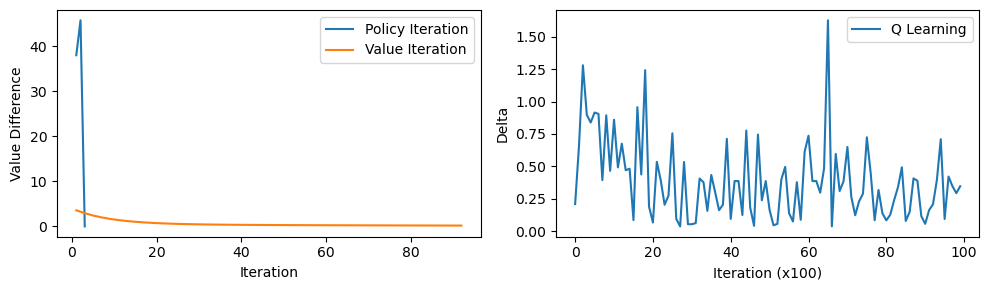

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))
d1 = pd.DataFrame(np.array(fm_sm_pi_val_li)).diff().max(1)
d2 = pd.DataFrame(np.array(fm_sm_vi_val_li)).diff().max(1)
axs[0].plot(d1, label='Policy Iteration')
axs[0].plot(d2, label='Value Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value Difference')
axs[0].legend()
axs[1].plot(fm_sm_ql_delta_li, label='Q Learning')
axs[1].set_xlabel('Iteration (x100)')
axs[1].set_ylabel('Delta')
axs[1].legend()
plt.tight_layout();

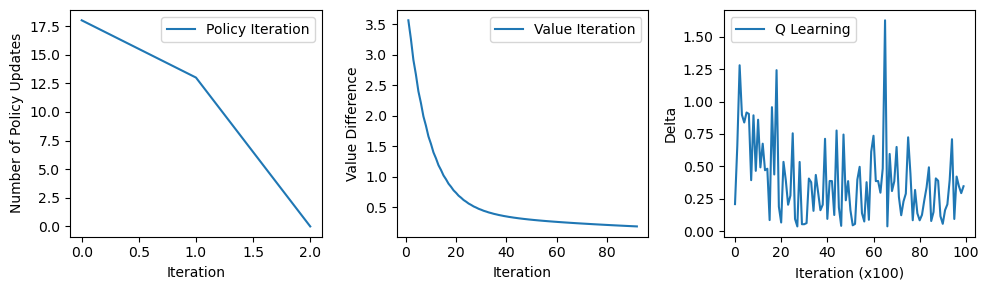

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].plot(fm_sm_pi_n_li, label='Policy Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Number of Policy Updates')
axs[0].legend()
axs[1].plot(pd.DataFrame(np.array(fm_sm_vi_val_li)).diff().max(1), label='Value Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value Difference')
axs[1].legend()
axs[2].plot(fm_sm_ql_delta_li, label='Q Learning')
axs[2].set_xlabel('Iteration (x100)')
axs[2].set_ylabel('Delta')
axs[2].legend()
plt.tight_layout();

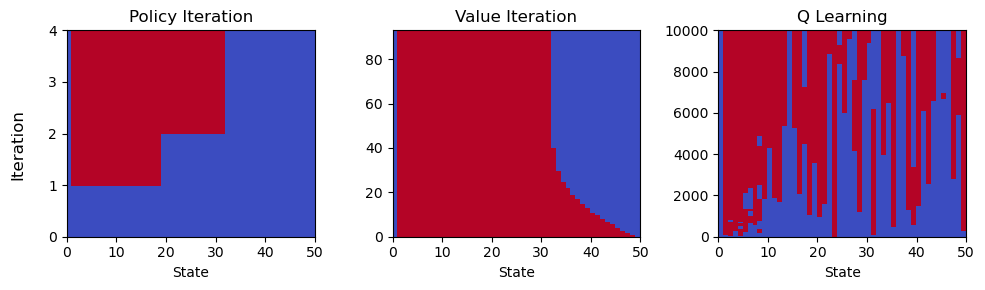

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].pcolor(np.array(fm_sm_pi_policy_li), cmap='coolwarm')
# axs[0].set_xticks(np.arange(0,51,2))
# axs[0].set_yticks(np.arange(len(fm_sm_pi_policy_li)+1))
# axs[0].set_ylabel('Iteration')
axs[0].set_xlabel('State')
axs[0].set_title('Policy Iteration')
# axs[0].set_colorbar();
axs[1].pcolor(np.array(fm_sm_vi_policy_li), cmap='coolwarm')
# axs[1].set_xticks(np.arange(0,51,2))
# axs[1].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[1].set_ylabel('Iteration')
axs[1].set_xlabel('State')
axs[1].set_title('Value Iteration')
axs[2].pcolor(np.array(fm_sm_ql_policy_li), cmap='coolwarm')
# axs[2].set_xticks(np.arange(0,51,2))
# axs[2].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[2].set_ylabel('Iteration')
axs[2].set_xlabel('State')
axs[2].set_title('Q Learning')
fig.supylabel('Iteration')
# fig.suptitle('Policy at Each Iteration')
plt.tight_layout();

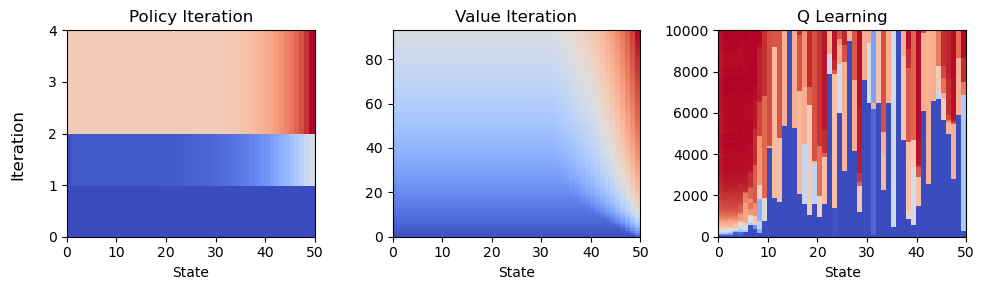

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].pcolor(np.array(fm_sm_pi_val_li), cmap='coolwarm')
# axs[0].set_xticks(np.arange(0,51,2))
# axs[0].set_yticks(np.arange(len(fm_sm_pi_policy_li)+1))
# axs[0].set_ylabel('Iteration')
axs[0].set_xlabel('State')
axs[0].set_title('Policy Iteration')
# axs[0].set_colorbar();
axs[1].pcolor(np.array(fm_sm_vi_val_li), cmap='coolwarm')
# axs[1].set_xticks(np.arange(0,51,2))
# axs[1].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[1].set_ylabel('Iteration')
axs[1].set_xlabel('State')
axs[1].set_title('Value Iteration')
axs[2].pcolor(np.array(fm_sm_ql_val_li), cmap='coolwarm')
# axs[2].set_xticks(np.arange(0,51,2))
# axs[2].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[2].set_ylabel('Iteration')
axs[2].set_xlabel('State')
axs[2].set_title('Q Learning')
fig.supylabel('Iteration')
# fig.suptitle('Value at Each Iteration')
plt.tight_layout();

### large

In [30]:
fm_lg_P, fm_lg_R = mdptoolbox.example.forest(S=500, r1=4, r2=2, p=0.1)

Policy Iteration

In [31]:
fm_lg_pi = PolicyIteration(fm_lg_P, fm_lg_R, .99, policy0=np.zeros(len(fm_lg_R)))
# fm_lg_pi.setVerbose()
fm_lg_pi_policy_li, fm_lg_pi_val_li, fm_lg_pi_n_li = fm_lg_pi.run()

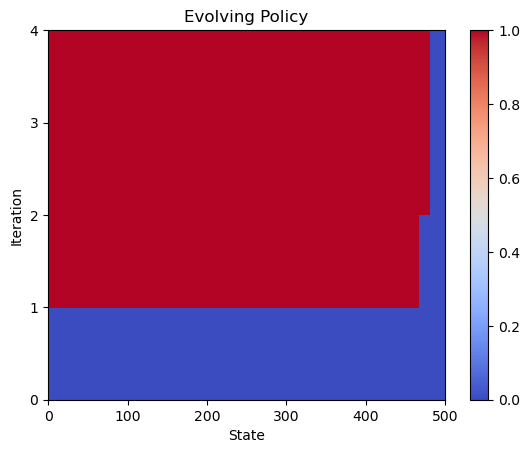

In [32]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_lg_pi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
plt.yticks(np.arange(len(fm_lg_pi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

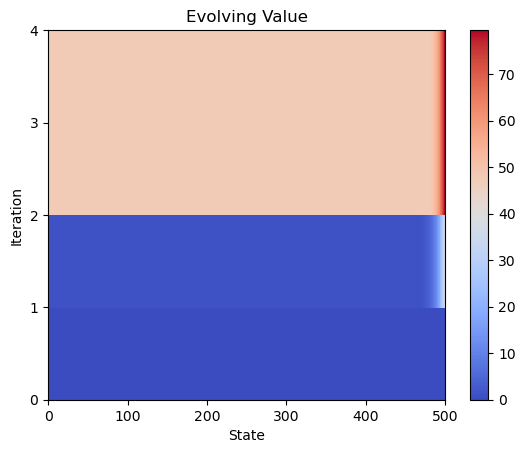

In [33]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_lg_pi_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2)) 
plt.yticks(np.arange(len(fm_lg_pi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

Value Iteration

In [34]:
fm_lg_vi = ValueIteration(fm_lg_P, fm_lg_R, .99)
# fm_lg_vi.setVerbose()
fm_lg_vi_policy_li, fm_lg_vi_val_li = fm_lg_vi.run()

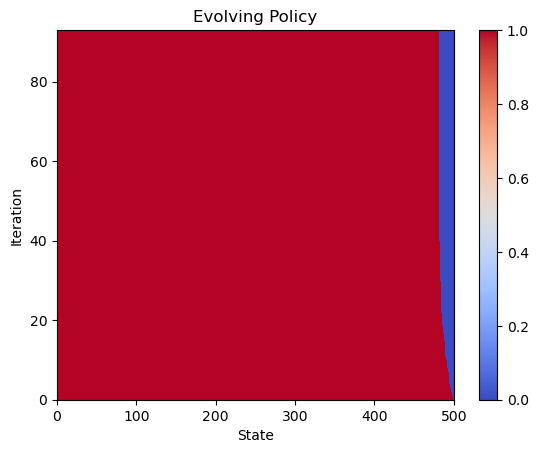

In [35]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_lg_vi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

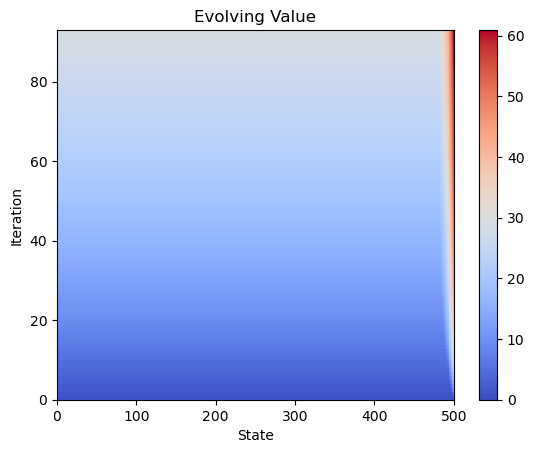

In [36]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_lg_vi_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

Q Learning

In [37]:
fm_lg_ql = QLearning(fm_lg_P, fm_lg_R, .99, 
                     learning_rate = 0.5, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_lg_ql.setVerbose()
fm_lg_ql_policy_li, fm_lg_ql_val_li, fm_lg_ql_q_li, fm_lg_ql_delta_li = fm_lg_ql.run()

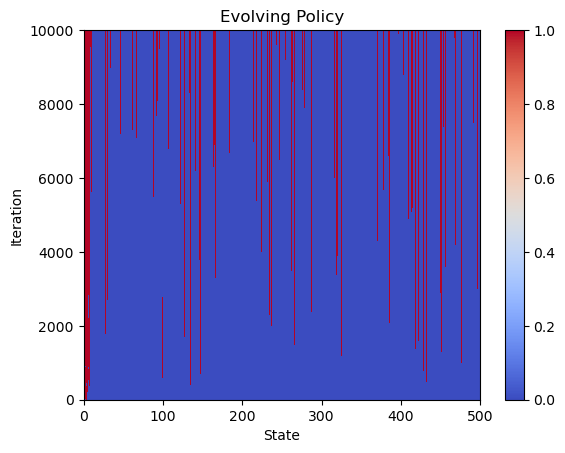

In [38]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_lg_ql_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_ql_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

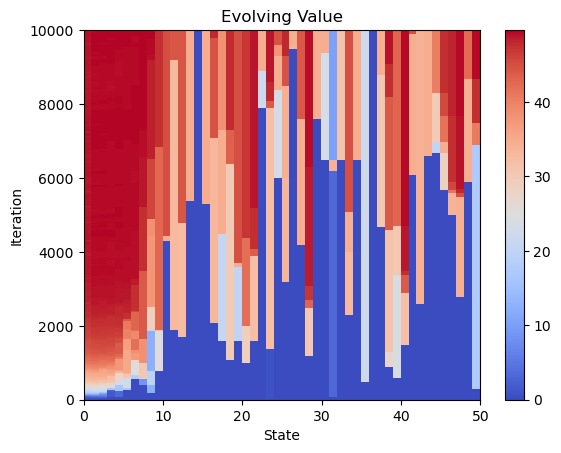

In [39]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fm_sm_ql_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

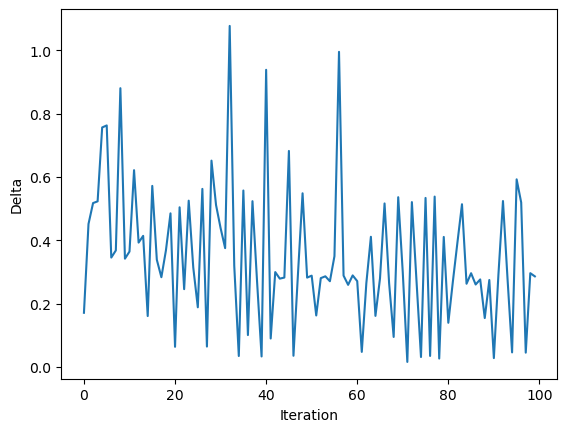

In [40]:
plt.plot(fm_lg_ql_delta_li)
plt.xlabel('Iteration')
plt.ylabel('Delta');

In [41]:
np.mean(fm_lg_pi.V), np.mean(fm_lg_vi.V), np.mean(fm_lg_ql.V)

(48.060037316419574, 29.457916602531448, 5.37708244100694)

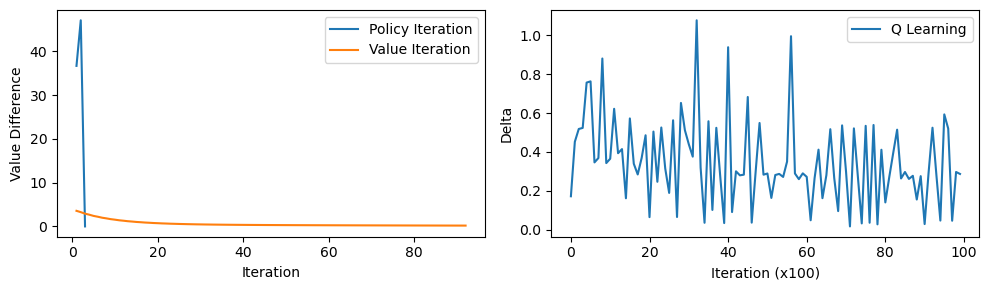

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))
d1 = pd.DataFrame(np.array(fm_lg_pi_val_li)).diff().max(1)
d2 = pd.DataFrame(np.array(fm_lg_vi_val_li)).diff().max(1)
axs[0].plot(d1, label='Policy Iteration')
axs[0].plot(d2, label='Value Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value Difference')
axs[0].legend()
axs[1].plot(fm_lg_ql_delta_li, label='Q Learning')
axs[1].set_xlabel('Iteration (x100)')
axs[1].set_ylabel('Delta')
axs[1].legend()
plt.tight_layout();

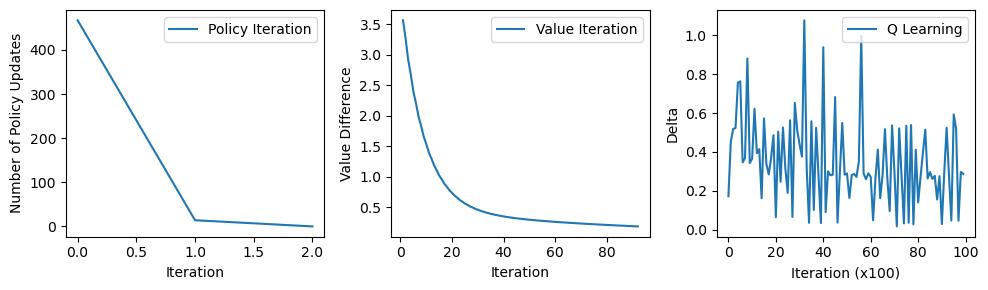

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].plot(fm_lg_pi_n_li, label='Policy Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Number of Policy Updates')
axs[0].legend()
axs[1].plot(pd.DataFrame(np.array(fm_lg_vi_val_li)).diff().max(1), label='Value Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value Difference')
axs[1].legend()
axs[2].plot(fm_lg_ql_delta_li, label='Q Learning')
axs[2].set_xlabel('Iteration (x100)')
axs[2].set_ylabel('Delta')
axs[2].legend()
plt.tight_layout();

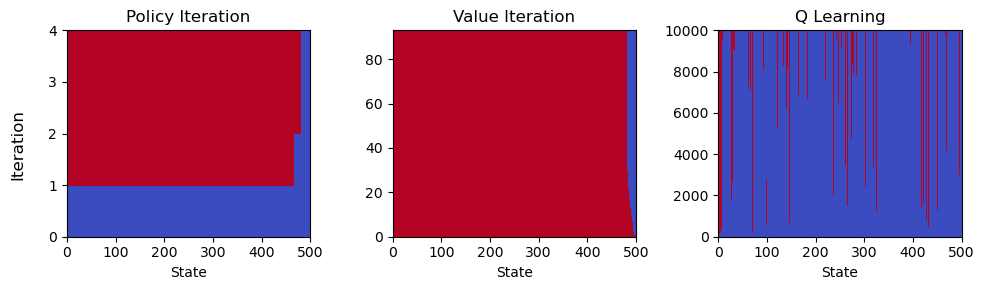

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].pcolor(np.array(fm_lg_pi_policy_li), cmap='coolwarm')
# axs[0].set_xticks(np.arange(0,51,2))
# axs[0].set_yticks(np.arange(len(fm_sm_pi_policy_li)+1))
# axs[0].set_ylabel('Iteration')
axs[0].set_xlabel('State')
axs[0].set_title('Policy Iteration')
# axs[0].set_colorbar();
axs[1].pcolor(np.array(fm_lg_vi_policy_li), cmap='coolwarm')
# axs[1].set_xticks(np.arange(0,51,2))
# axs[1].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[1].set_ylabel('Iteration')
axs[1].set_xlabel('State')
axs[1].set_title('Value Iteration')
axs[2].pcolor(np.array(fm_lg_ql_policy_li), cmap='coolwarm')
# axs[2].set_xticks(np.arange(0,51,2))
# axs[2].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[2].set_ylabel('Iteration')
axs[2].set_xlabel('State')
axs[2].set_title('Q Learning')
fig.supylabel('Iteration')
# fig.suptitle('Policy at Each Iteration')
plt.tight_layout();

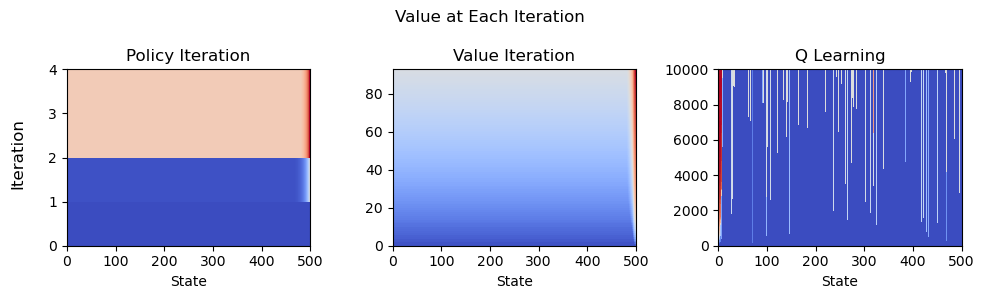

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].pcolor(np.array(fm_lg_pi_val_li), cmap='coolwarm')
# axs[0].set_xticks(np.arange(0,51,2))
# axs[0].set_yticks(np.arange(len(fm_sm_pi_policy_li)+1))
# axs[0].set_ylabel('Iteration')
axs[0].set_xlabel('State')
axs[0].set_title('Policy Iteration')
# axs[0].set_colorbar();
axs[1].pcolor(np.array(fm_lg_vi_val_li), cmap='coolwarm')
# axs[1].set_xticks(np.arange(0,51,2))
# axs[1].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[1].set_ylabel('Iteration')
axs[1].set_xlabel('State')
axs[1].set_title('Value Iteration')
axs[2].pcolor(np.array(fm_lg_ql_val_li), cmap='coolwarm')
# axs[2].set_xticks(np.arange(0,51,2))
# axs[2].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[2].set_ylabel('Iteration')
axs[2].set_xlabel('State')
axs[2].set_title('Q Learning')
fig.supylabel('Iteration')
fig.suptitle('Value at Each Iteration')
plt.tight_layout();

## Frozen Lake

In [46]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

In [47]:
def plot_lake(env, policy=None, value=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=.1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                policy = np.array(policy).reshape(squares,squares)
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=15, verticalalignment='center',
                               color='k')
            
            if value is not None:
                value = np.array(value).reshape(squares,squares)
                text = ax.text(x+0.5, y+0.5, int(value[i, j]*100),
                               horizontalalignment='center', verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    # plt.savefig('./frozen/' + title + '.png', dpi=400)

### small

In [48]:
fl_sm_env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=True)
fl_sm_env.reset()

0

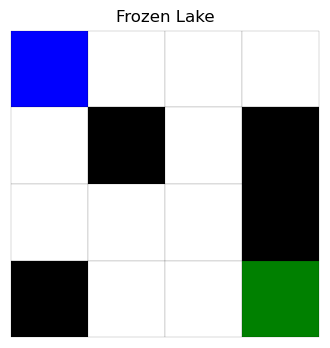

In [49]:
plot_lake(fl_sm_env)

In [50]:
# fl_sm_env.P[2][2]

In [51]:
# Transition matrix
fl_sm_P = np.zeros((fl_sm_env.action_space.n, fl_sm_env.observation_space.n, fl_sm_env.observation_space.n))
for s0 in fl_sm_env.P.keys():
    for a in fl_sm_env.P[s0].keys():
        for p, s1, r, done in fl_sm_env.P[s0][a]:
            fl_sm_P[a, s0, s1] += p

In [52]:
# Reward matrix
fl_sm_R = np.zeros((fl_sm_env.observation_space.n, fl_sm_env.action_space.n))
for s0 in fl_sm_env.P.keys():
    for a in fl_sm_env.P[s0].keys():
        for p, s1, r, done in fl_sm_env.P[s0][a]:
            fl_sm_R[s0, a] += p * r

Policy Iteration

In [53]:
fl_sm_pi = PolicyIteration(fl_sm_P, fl_sm_R, .99)
# fl_sm_pi.setVerbose()
fl_sm_pi_policy_li, fl_sm_pi_val_li, fl_sm_pi_n_li = fl_sm_pi.run()

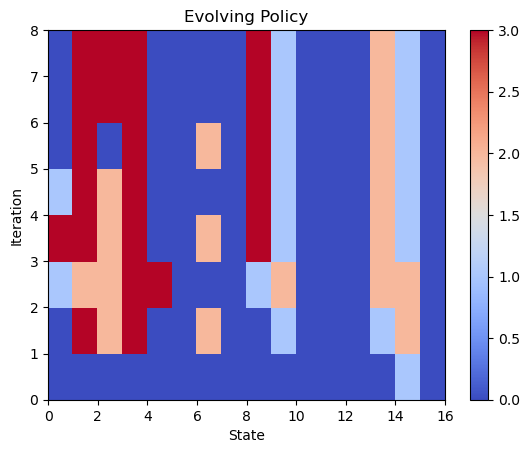

In [54]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_sm_pi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
plt.yticks(np.arange(len(fl_sm_pi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

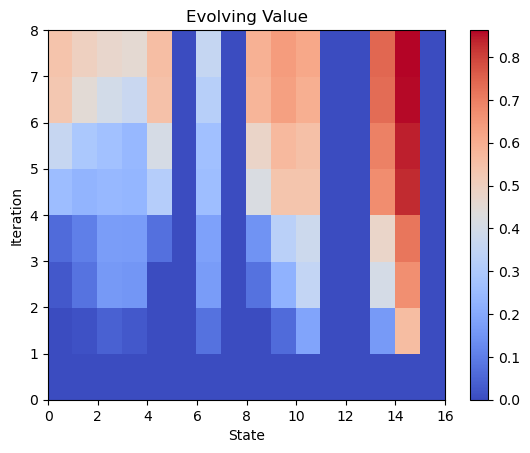

In [55]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_sm_pi_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
plt.yticks(np.arange(len(fl_sm_pi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

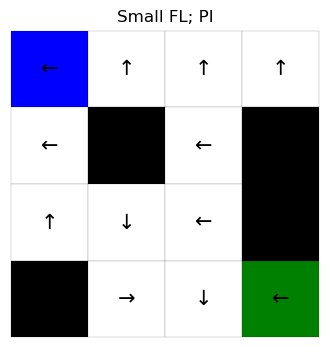

In [56]:
plot_lake(fl_sm_env, fl_sm_pi.policy, title='Small FL; PI')

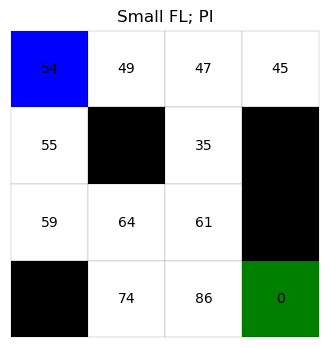

In [57]:
plot_lake(fl_sm_env, None, fl_sm_pi.V, title='Small FL; PI')

Value Iteration

In [58]:
fl_sm_vi = ValueIteration(fl_sm_P, fl_sm_R, .99)
# fl_sm_vi.setVerbose()
fl_sm_vi_policy_li, fl_sm_vi_val_li = fl_sm_vi.run()

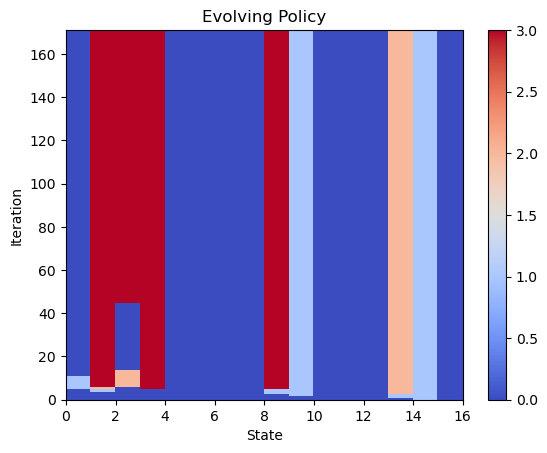

In [59]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_sm_vi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

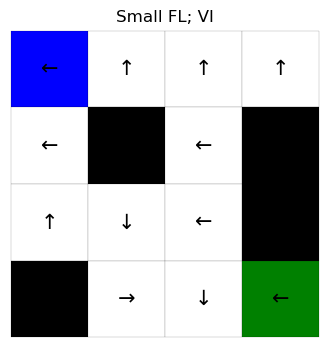

In [60]:
plot_lake(fl_sm_env, fl_sm_vi.policy, title='Small FL; VI')

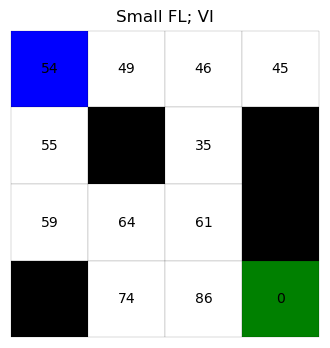

In [61]:
plot_lake(fl_sm_env, None, fl_sm_vi.V, title='Small FL; VI')

In [62]:
# pd.DataFrame(np.array(fl_sm_pi_val_li)).diff().max(1).plot()
# pd.DataFrame(np.array(fl_sm_vi_val_li)).diff().max(1).plot()
# plt.xlabel('Iteration')
# plt.ylabel('Value Difference');

Q Learning

In [63]:
fl_sm_ql = QLearning(fl_sm_P, fl_sm_R, .99,
                     learning_rate = 0.5, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.01, 
                     exploration_decay_rate = 0.001)
# fl_sm_ql.setVerbose()
fl_sm_ql_policy_li, fl_sm_ql_val_li, fl_sm_ql_q_li, fl_sm_ql_delta_li = fl_sm_ql.run()

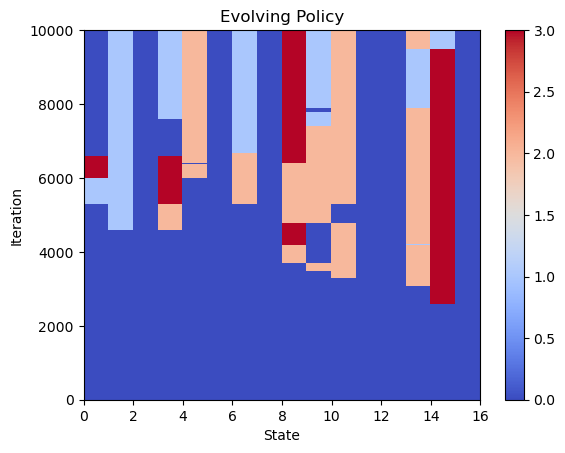

In [64]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_sm_ql_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_ql_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

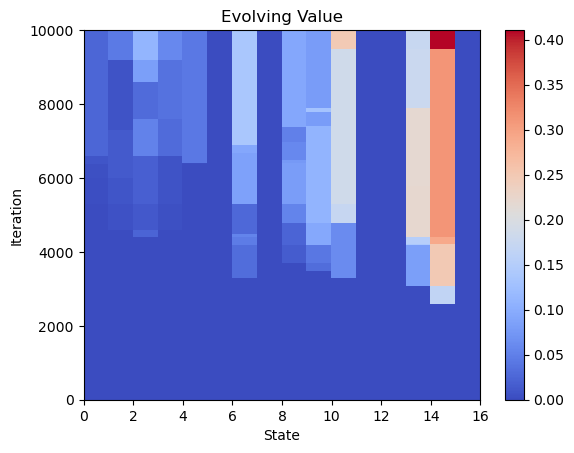

In [65]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_sm_ql_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

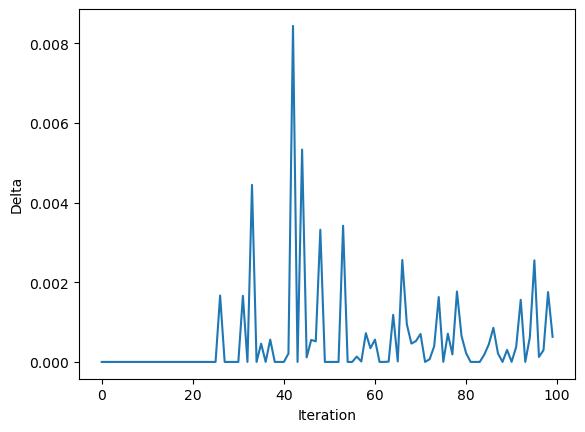

In [66]:
plt.plot(fl_sm_ql_delta_li)
plt.xlabel('Iteration')
plt.ylabel('Delta');

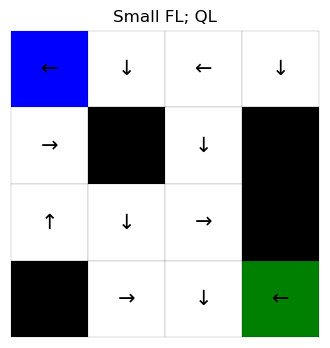

In [67]:
plot_lake(fl_sm_env, fl_sm_ql.policy, title='Small FL; QL')

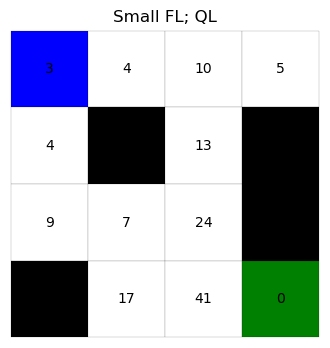

In [68]:
plot_lake(fl_sm_env, None, fl_sm_ql.V, title='Small FL; QL')

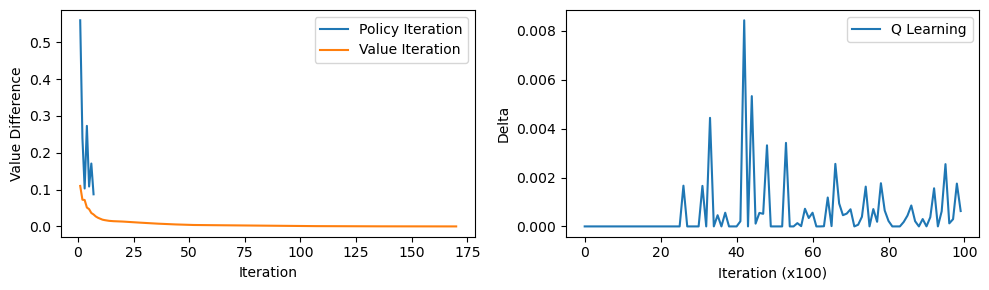

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))
d1 = pd.DataFrame(np.array(fl_sm_pi_val_li)).diff().max(1)
d2 = pd.DataFrame(np.array(fl_sm_vi_val_li)).diff().max(1)
axs[0].plot(d1, label='Policy Iteration')
axs[0].plot(d2, label='Value Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value Difference')
axs[0].legend()
axs[1].plot(fl_sm_ql_delta_li, label='Q Learning')
axs[1].set_xlabel('Iteration (x100)')
axs[1].set_ylabel('Delta')
axs[1].legend()
plt.tight_layout();

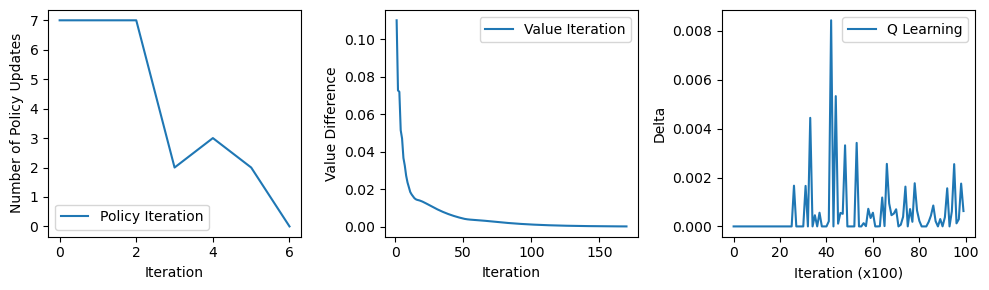

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].plot(fl_sm_pi_n_li, label='Policy Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Number of Policy Updates')
axs[0].legend()
axs[1].plot(pd.DataFrame(np.array(fl_sm_vi_val_li)).diff().max(1), label='Value Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value Difference')
axs[1].legend()
axs[2].plot(fl_sm_ql_delta_li, label='Q Learning')
axs[2].set_xlabel('Iteration (x100)')
axs[2].set_ylabel('Delta')
axs[2].legend()
plt.tight_layout();

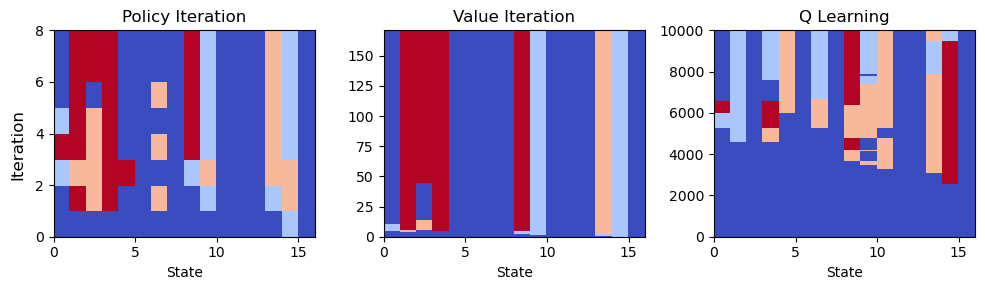

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].pcolor(np.array(fl_sm_pi_policy_li), cmap='coolwarm')
# axs[0].set_xticks(np.arange(0,51,2))
# axs[0].set_yticks(np.arange(len(fm_sm_pi_policy_li)+1))
# axs[0].set_ylabel('Iteration')
axs[0].set_xlabel('State')
axs[0].set_title('Policy Iteration')
# axs[0].set_colorbar();
axs[1].pcolor(np.array(fl_sm_vi_policy_li), cmap='coolwarm')
# axs[1].set_xticks(np.arange(0,51,2))
# axs[1].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[1].set_ylabel('Iteration')
axs[1].set_xlabel('State')
axs[1].set_title('Value Iteration')
axs[2].pcolor(np.array(fl_sm_ql_policy_li), cmap='coolwarm')
# axs[2].set_xticks(np.arange(0,51,2))
# axs[2].set_yticks(np.arange(len(fm_sm_vi_policy_li)+1))
# axs[2].set_ylabel('Iteration')
axs[2].set_xlabel('State')
axs[2].set_title('Q Learning')
fig.supylabel('Iteration')
# fig.suptitle('Policy at Each Iteration')
plt.tight_layout();

### large

In [72]:
random_map = generate_random_map(size=20, p=0.8)
fl_lg_env = gym.make('FrozenLake-v1', desc=random_map, is_slippery=True)
fl_lg_env.reset()

0

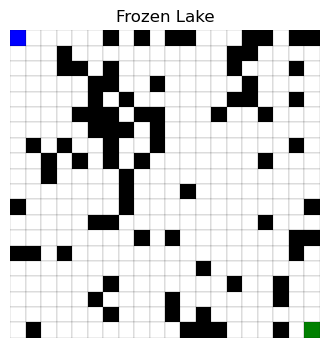

In [73]:
plot_lake(fl_lg_env)

In [74]:
# transition matrix
fl_lg_P = np.zeros((fl_lg_env.action_space.n, fl_lg_env.observation_space.n, fl_lg_env.observation_space.n))
for s0 in fl_lg_env.P.keys():
    for a in fl_lg_env.P[s0].keys():
        for p, s1, r, done in fl_lg_env.P[s0][a]:
            fl_lg_P[a, s0, s1] += p

In [75]:
# reward matrix
fl_lg_R = np.zeros((fl_lg_env.observation_space.n, fl_lg_env.action_space.n))
for s0 in fl_lg_env.P.keys():
    for a in fl_lg_env.P[s0].keys():
        for p, s1, r, done in fl_lg_env.P[s0][a]:
            fl_lg_R[s0, a] += p * r

Policy Iteration

In [76]:
fl_lg_pi = PolicyIteration(fl_lg_P, fl_lg_R, .99, policy0=np.zeros(len(fl_lg_R)))
# fl_lg_pi.setVerbose()
fl_lg_pi_policy_li, fl_lg_pi_val_li, fl_lg_pi_n_li= fl_lg_pi.run()

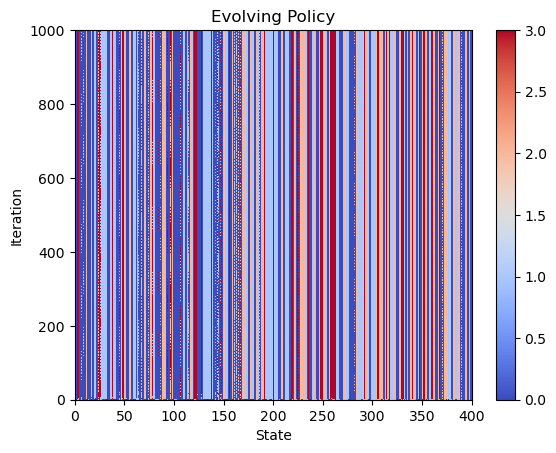

In [77]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_pi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fl_lg_pi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

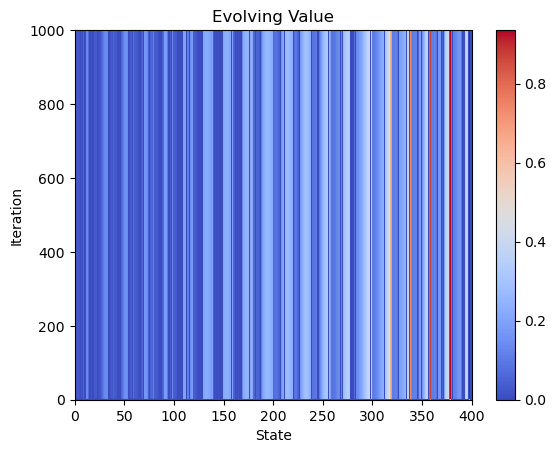

In [78]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_pi_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2)) 
# plt.yticks(np.arange(len(fl_lg_pi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

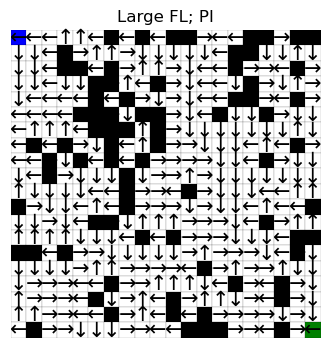

In [79]:
plot_lake(fl_lg_env, fl_lg_pi.policy, title='Large FL; PI')

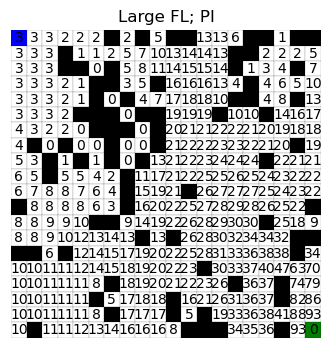

In [80]:
plot_lake(fl_lg_env, None, fl_lg_pi.V, title='Large FL; PI')

Value Iteration

In [81]:
fl_lg_vi = ValueIteration(fl_lg_P, fl_lg_R, .99)
# fl_lg_vi.setVerbose()
fl_lg_vi_policy_li, fl_lg_vi_val_li = fl_lg_vi.run()

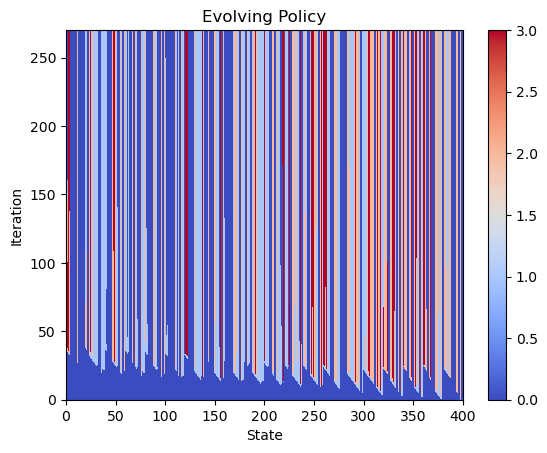

In [82]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_vi_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

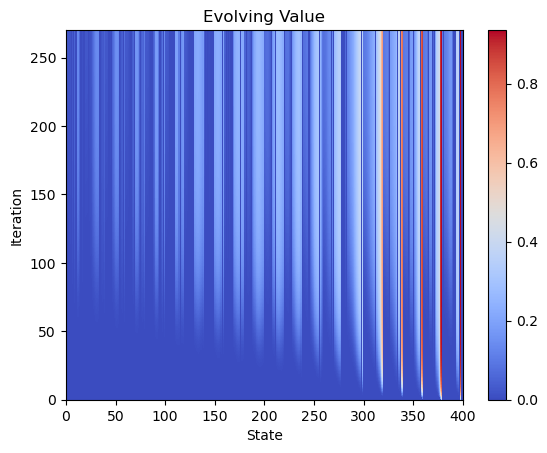

In [83]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_vi_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

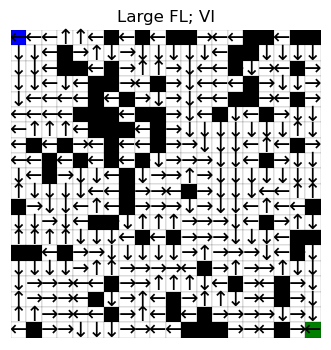

In [84]:
plot_lake(fl_lg_env, fl_lg_vi.policy, title='Large FL; VI')

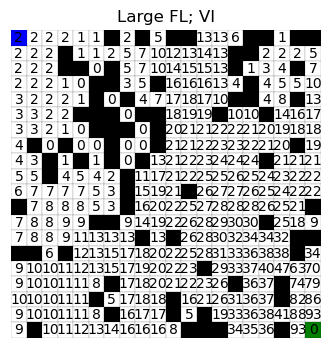

In [85]:
plot_lake(fl_lg_env, None, fl_lg_vi.V, title='Large FL; VI')

In [86]:
# pd.DataFrame(np.array(fl_lg_pi_val_li)).diff().max(1).plot()
# pd.DataFrame(np.array(fl_lg_vi_val_li)).diff().max(1).plot()
# plt.xlabel('Iteration')
# plt.ylabel('Value Difference');

Q Learning

In [87]:
fl_lg_ql = QLearning(fl_lg_P, fl_lg_R, .99,
                     learning_rate = 0.5, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.01, 
                     exploration_decay_rate = 0.0001)
# fl_lg_ql.setVerbose()
fl_lg_ql_policy_li, fl_lg_ql_val_li, fl_lg_ql_q_li, fl_lg_ql_delta_li = fl_lg_ql.run()

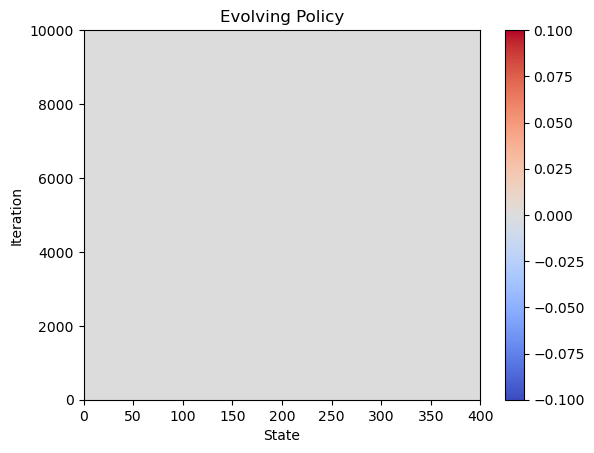

In [88]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_ql_policy_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_ql_policy_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Policy')
plt.colorbar();

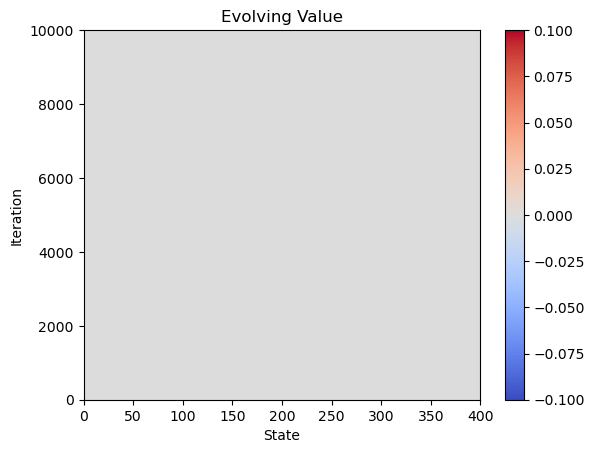

In [89]:
# plt.figure(figsize=(10,2))
plt.pcolor(np.array(fl_lg_ql_val_li), cmap='coolwarm')
# plt.xticks(np.arange(0,51,2))
# plt.yticks(np.arange(len(fm_sm_vi_val_li)+1))
plt.ylabel('Iteration')
plt.xlabel('State')
plt.title('Evolving Value')
plt.colorbar();

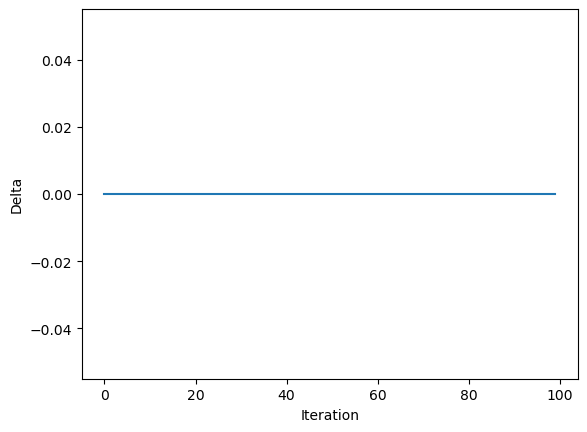

In [90]:
plt.plot(fl_lg_ql_delta_li)
plt.xlabel('Iteration')
plt.ylabel('Delta');

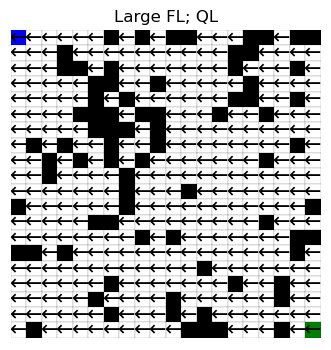

In [91]:
plot_lake(fl_lg_env,fl_lg_ql.policy,title='Large FL; QL')

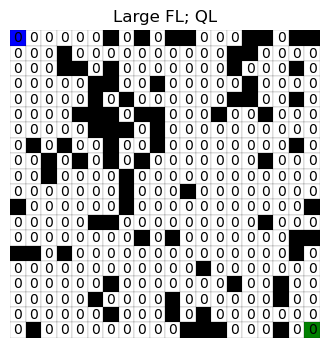

In [92]:
plot_lake(fl_lg_env,None,fl_lg_ql.V, title='Large FL; QL')

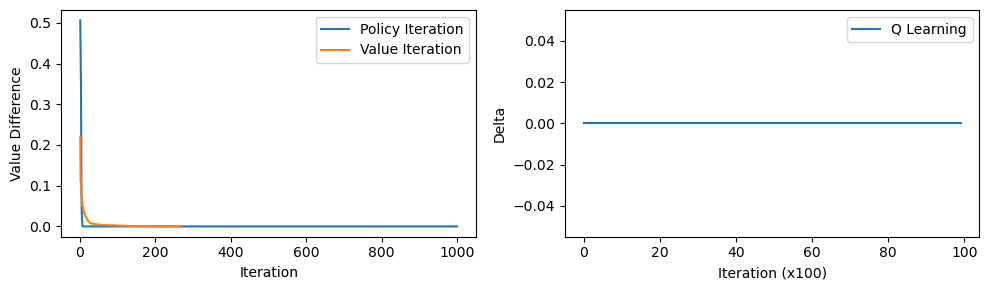

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(10,3))
d1 = pd.DataFrame(np.array(fl_lg_pi_val_li)).diff().max(1)
d2 = pd.DataFrame(np.array(fl_lg_vi_val_li)).diff().max(1)
axs[0].plot(d1, label='Policy Iteration')
axs[0].plot(d2, label='Value Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value Difference')
axs[0].legend()
axs[1].plot(fl_lg_ql_delta_li, label='Q Learning')
axs[1].set_xlabel('Iteration (x100)')
axs[1].set_ylabel('Delta')
axs[1].legend()
plt.tight_layout();

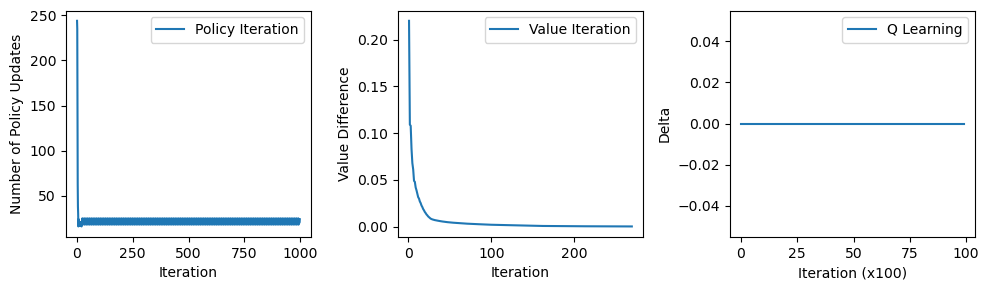

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].plot(fl_lg_pi_n_li, label='Policy Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Number of Policy Updates')
axs[0].legend()
axs[1].plot(pd.DataFrame(np.array(fl_lg_vi_val_li)).diff().max(1), label='Value Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value Difference')
axs[1].legend()
axs[2].plot(fl_lg_ql_delta_li, label='Q Learning')
axs[2].set_xlabel('Iteration (x100)')
axs[2].set_ylabel('Delta')
axs[2].legend()
plt.tight_layout();

Hyperparameters

gamma

In [95]:
# fm_lg_pi = PolicyIteration(fm_lg_P, fm_lg_R, .99, policy0=np.zeros(len(fm_lg_R)))
# # fm_lg_pi.setVerbose()
# fm_lg_pi_policy_li, fm_lg_pi_val_li, fm_lg_pi_n_li = fm_lg_pi.run()

fm_sm_pi9 = PolicyIteration(fm_sm_P, fm_sm_R, .9, policy0=np.zeros(len(fm_sm_R)))
# fm_lg_pi.setVerbose()
fm_sm_pi_policy_li9, fm_sm_pi_val_li9, fm_sm_pi_n_li9 = fm_sm_pi9.run()

fm_sm_pi7 = PolicyIteration(fm_sm_P, fm_sm_R, .7, policy0=np.zeros(len(fm_sm_R)))
# fm_lg_pi.setVerbose()
fm_sm_pi_policy_li7, fm_sm_pi_val_li7, fm_sm_pi_n_li7 = fm_sm_pi7.run()

fm_sm_pi5 = PolicyIteration(fm_sm_P, fm_sm_R, .5, policy0=np.zeros(len(fm_sm_R)))
# fm_lg_pi.setVerbose()
fm_sm_pi_policy_li5, fm_sm_pi_val_li5, fm_sm_pi_n_li5 = fm_sm_pi5.run()

fm_sm_pi2 = PolicyIteration(fm_sm_P, fm_sm_R, .2, policy0=np.zeros(len(fm_sm_R)))
# fm_lg_pi.setVerbose()
fm_sm_pi_policy_li2, fm_sm_pi_val_li2, fm_sm_pi_n_li2 = fm_sm_pi2.run()

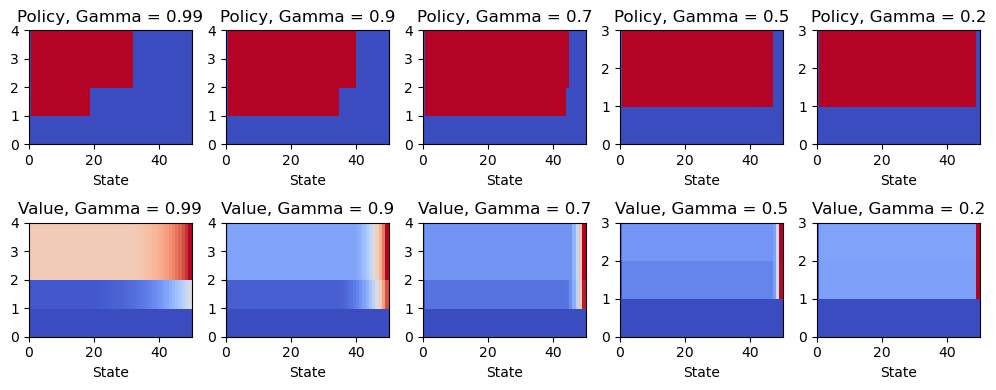

In [96]:
fig, axs = plt.subplots(2, 5, figsize=(10,4))
axs[0,0].pcolor(np.array(fm_sm_pi_policy_li), cmap='coolwarm')
axs[0,0].set_xlabel('State')
axs[0,0].set_title('Policy, Gamma = 0.99')

axs[0,1].pcolor(np.array(fm_sm_pi_policy_li9), cmap='coolwarm')
axs[0,1].set_xlabel('State')
axs[0,1].set_title('Policy, Gamma = 0.9')

axs[0,2].pcolor(np.array(fm_sm_pi_policy_li7), cmap='coolwarm')
axs[0,2].set_xlabel('State')
axs[0,2].set_title('Policy, Gamma = 0.7')

axs[0,3].pcolor(np.array(fm_sm_pi_policy_li5), cmap='coolwarm')
axs[0,3].set_xlabel('State')
axs[0,3].set_title('Policy, Gamma = 0.5')

axs[0,4].pcolor(np.array(fm_sm_pi_policy_li2), cmap='coolwarm')
axs[0,4].set_xlabel('State')
axs[0,4].set_title('Policy, Gamma = 0.2')

axs[1,0].pcolor(np.array(fm_sm_pi_val_li), cmap='coolwarm')
axs[1,0].set_xlabel('State')
axs[1,0].set_title('Value, Gamma = 0.99')

axs[1,1].pcolor(np.array(fm_sm_pi_val_li9), cmap='coolwarm')
axs[1,1].set_xlabel('State')
axs[1,1].set_title('Value, Gamma = 0.9')

axs[1,2].pcolor(np.array(fm_sm_pi_val_li7), cmap='coolwarm')
axs[1,2].set_xlabel('State')
axs[1,2].set_title('Value, Gamma = 0.7')

axs[1,3].pcolor(np.array(fm_sm_pi_val_li5), cmap='coolwarm')
axs[1,3].set_xlabel('State')
axs[1,3].set_title('Value, Gamma = 0.5')

axs[1,4].pcolor(np.array(fm_sm_pi_val_li2), cmap='coolwarm')
axs[1,4].set_xlabel('State')
axs[1,4].set_title('Value, Gamma = 0.2')

plt.tight_layout();

epsilon greedy

In [97]:
decay = lambda n, rate: .001 + (1-.001) * np.exp(-rate * n)

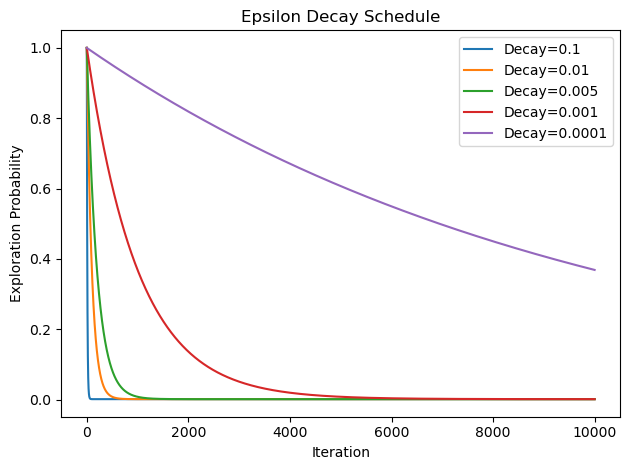

In [98]:
plt.plot([decay(n,.1) for n in range(10000)], label='Decay=0.1')
plt.plot([decay(n,.01) for n in range(10000)], label='Decay=0.01')
plt.plot([decay(n,.005) for n in range(10000)], label='Decay=0.005')
plt.plot([decay(n,.001) for n in range(10000)], label='Decay=0.001')
plt.plot([decay(n,.0001) for n in range(10000)], label='Decay=0.0001')
plt.xlabel('Iteration')
plt.ylabel('Exploration Probability')
plt.legend()
plt.title('Epsilon Decay Schedule')
plt.tight_layout();

In [112]:
fm_sm_ql1 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.7, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.1)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li1, fm_sm_ql_val_li1, fm_sm_ql_q_li1, fm_sm_ql_delta_li1 = fm_sm_ql1.run()

fm_sm_ql01 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.7, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.01)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li01, fm_sm_ql_val_li01, fm_sm_ql_q_li01, fm_sm_ql_delta_li01 = fm_sm_ql01.run()

fm_sm_ql001 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.7, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.001)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li001, fm_sm_ql_val_li001, fm_sm_ql_q_li001, fm_sm_ql_delta_li001 = fm_sm_ql001.run()

fm_sm_ql0001 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.7, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.0001)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li0001, fm_sm_ql_val_li0001, fm_sm_ql_q_li0001, fm_sm_ql_delta_li0001 = fm_sm_ql0001.run()

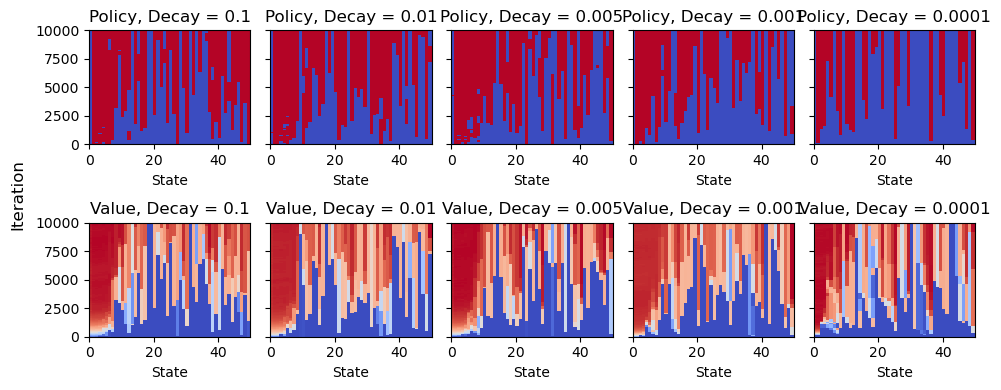

In [100]:
fig, axs = plt.subplots(2, 5, figsize=(10,4), sharey=True)
axs[0,0].pcolor(np.array(fm_sm_ql_policy_li1), cmap='coolwarm')
axs[0,0].set_xlabel('State')
axs[0,0].set_title('Policy, Decay = 0.1')

axs[0,1].pcolor(np.array(fm_sm_ql_policy_li01), cmap='coolwarm')
axs[0,1].set_xlabel('State')
axs[0,1].set_title('Policy, Decay = 0.01')

axs[0,2].pcolor(np.array(fm_sm_ql_policy_li), cmap='coolwarm')
axs[0,2].set_xlabel('State')
axs[0,2].set_title('Policy, Decay = 0.005')

axs[0,3].pcolor(np.array(fm_sm_ql_policy_li001), cmap='coolwarm')
axs[0,3].set_xlabel('State')
axs[0,3].set_title('Policy, Decay = 0.001')

axs[0,4].pcolor(np.array(fm_sm_ql_policy_li0001), cmap='coolwarm')
axs[0,4].set_xlabel('State')
axs[0,4].set_title('Policy, Decay = 0.0001')

axs[1,0].pcolor(np.array(fm_sm_ql_val_li1), cmap='coolwarm')
axs[1,0].set_xlabel('State')
axs[1,0].set_title('Value, Decay = 0.1')

axs[1,1].pcolor(np.array(fm_sm_ql_val_li01), cmap='coolwarm')
axs[1,1].set_xlabel('State')
axs[1,1].set_title('Value, Decay = 0.01')

axs[1,2].pcolor(np.array(fm_sm_ql_val_li), cmap='coolwarm')
axs[1,2].set_xlabel('State')
axs[1,2].set_title('Value, Decay = 0.005')

axs[1,3].pcolor(np.array(fm_sm_ql_val_li001), cmap='coolwarm')
axs[1,3].set_xlabel('State')
axs[1,3].set_title('Value, Decay = 0.001')

axs[1,4].pcolor(np.array(fm_sm_ql_val_li0001), cmap='coolwarm')
axs[1,4].set_xlabel('State')
axs[1,4].set_title('Value, Decay = 0.0001')
fig.supylabel('Iteration')
plt.tight_layout();

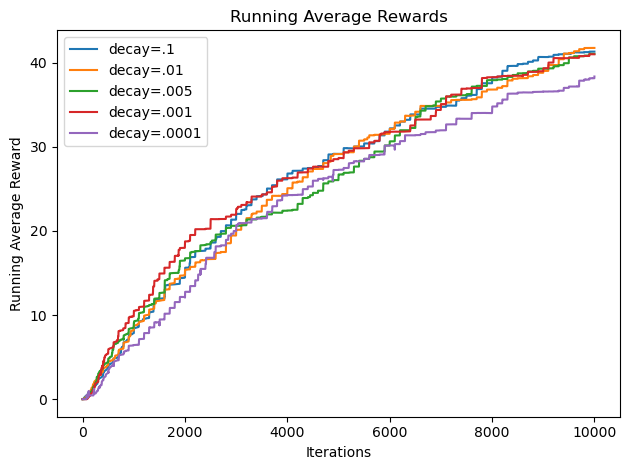

In [114]:
plt.plot(np.array(fm_sm_ql_val_li1).mean(1), label='decay=.1')
plt.plot(np.array(fm_sm_ql_val_li01).mean(1), label='decay=.01')
plt.plot(np.array(fm_sm_ql_val_li).mean(1), label='decay=.005')
plt.plot(np.array(fm_sm_ql_val_li001).mean(1), label='decay=.001')
plt.plot(np.array(fm_sm_ql_val_li0001).mean(1), label='decay=.0001')
plt.xlabel('Iterations')
plt.ylabel('Running Average Reward')
plt.title('Running Average Rewards')
plt.legend()
plt.tight_layout();

In [101]:
fm_sm_ql9 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.9, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li9, fm_sm_ql_val_li9, fm_sm_ql_q_li9, fm_sm_ql_delta_li9 = fm_sm_ql9.run()

fm_sm_ql5 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.5, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li5, fm_sm_ql_val_li5, fm_sm_ql_q_li5, fm_sm_ql_delta_li5 = fm_sm_ql5.run()

fm_sm_ql2 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.2, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li2, fm_sm_ql_val_li2, fm_sm_ql_q_li2, fm_sm_ql_delta_li2 = fm_sm_ql2.run()

fm_sm_ql1 = QLearning(fm_sm_P, fm_sm_R, .99,
                     learning_rate = 0.1, exploration_rate = 1, 
                     max_exploration_rate = 1, min_exploration_rate = 0.001, 
                     exploration_decay_rate = 0.005)
# fm_sm_ql.setVerbose()
fm_sm_ql_policy_li1, fm_sm_ql_val_li1, fm_sm_ql_q_li1, fm_sm_ql_delta_li1 = fm_sm_ql1.run()

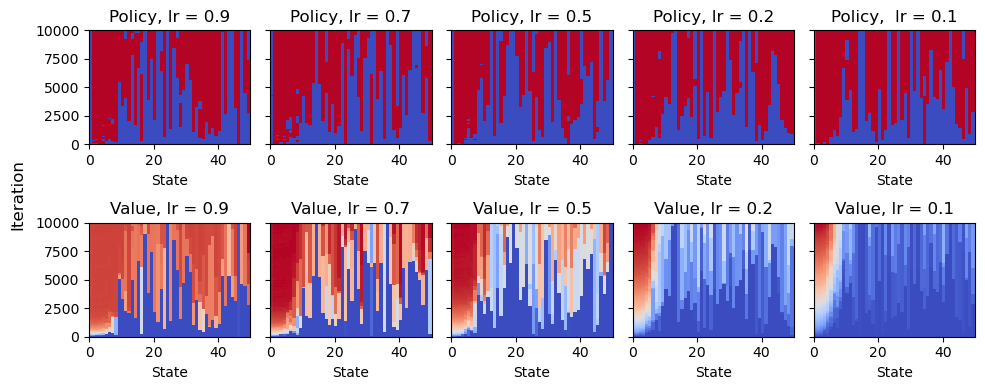

In [102]:
fig, axs = plt.subplots(2, 5, figsize=(10,4), sharey=True)
axs[0,0].pcolor(np.array(fm_sm_ql_policy_li9), cmap='coolwarm')
axs[0,0].set_xlabel('State')
axs[0,0].set_title('Policy, lr = 0.9')

axs[0,1].pcolor(np.array(fm_sm_ql_policy_li), cmap='coolwarm')
axs[0,1].set_xlabel('State')
axs[0,1].set_title('Policy, lr = 0.7')

axs[0,2].pcolor(np.array(fm_sm_ql_policy_li5), cmap='coolwarm')
axs[0,2].set_xlabel('State')
axs[0,2].set_title('Policy, lr = 0.5')

axs[0,3].pcolor(np.array(fm_sm_ql_policy_li2), cmap='coolwarm')
axs[0,3].set_xlabel('State')
axs[0,3].set_title('Policy, lr = 0.2')

axs[0,4].pcolor(np.array(fm_sm_ql_policy_li1), cmap='coolwarm')
axs[0,4].set_xlabel('State')
axs[0,4].set_title('Policy,  lr = 0.1')

axs[1,0].pcolor(np.array(fm_sm_ql_val_li9), cmap='coolwarm')
axs[1,0].set_xlabel('State')
axs[1,0].set_title('Value, lr = 0.9')

axs[1,1].pcolor(np.array(fm_sm_ql_val_li), cmap='coolwarm')
axs[1,1].set_xlabel('State')
axs[1,1].set_title('Value, lr = 0.7')

axs[1,2].pcolor(np.array(fm_sm_ql_val_li5), cmap='coolwarm')
axs[1,2].set_xlabel('State')
axs[1,2].set_title('Value, lr = 0.5')

axs[1,3].pcolor(np.array(fm_sm_ql_val_li2), cmap='coolwarm')
axs[1,3].set_xlabel('State')
axs[1,3].set_title('Value, lr = 0.2')

axs[1,4].pcolor(np.array(fm_sm_ql_val_li1), cmap='coolwarm')
axs[1,4].set_xlabel('State')
axs[1,4].set_title('Value, lr = 0.1')
fig.supylabel('Iteration')
plt.tight_layout();

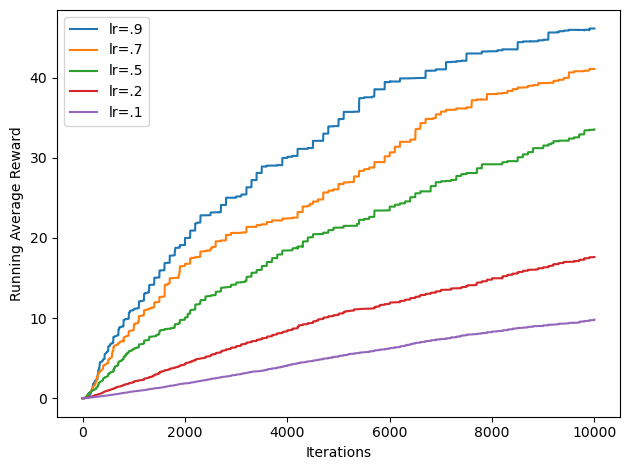

In [111]:
plt.plot(np.array(fm_sm_ql_val_li9).mean(1), label='lr=.9')
plt.plot(np.array(fm_sm_ql_val_li).mean(1), label='lr=.7')
plt.plot(np.array(fm_sm_ql_val_li5).mean(1), label='lr=.5')
plt.plot(np.array(fm_sm_ql_val_li2).mean(1), label='lr=.2')
plt.plot(np.array(fm_sm_ql_val_li1).mean(1), label='lr=.1')
plt.xlabel('Iterations')
plt.ylabel('Running Average Reward')
plt.legend()
plt.tight_layout();